In [3]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pickle
import h5py
import seaborn as sns
import pandas as pd
from scipy.stats import pearsonr
root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)

import torch
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from torch.utils.data import Subset

from predify.utils.training import train_pcoders, eval_pcoders

from networks_2022 import BranchedNetwork
from data.CleanSoundsDataset import CleanSoundsDataset

import sklearn.metrics
import scipy.io

In [4]:
def timeAverage(activations,  layer):
        dimension = np.shape(activations)
        if 'fc6' != layer:
            curr = np.mean(activations, axis = 2) #Average across time - current dimensions are [num_stim, frequency, time, kernels]
            curr = np.reshape(curr, (dimension[0], dimension[1] * dimension[3]))
        else:
            curr = activations
        return curr

In [5]:
def runPcaDecomp(avg_across_reps, n_pcs, return_s = False):
    """
    decomposes voxel matrix into IC voxel weights and IC response profiles; i.e.,

      (n_voxels, n_stim)  = (n_voxels, n_pcs) x (n_pcs, n_stim)
      avg_across_reps     = voxel_weights_on_each_IC x IC_response_profiles.T

    0) runs pca [svd] to reduce dimensionality to given subspace
    1) projects data into subspace
    2) runs ica [fastica] in that subspace

    returns: ica_response_profiles, ica_voxel_weights
    <n_pcs> determines the size of the PC subspace to project the data into before 
      running ICA
      -- if integer, use that number of PCs
      -- if None -- then use <self.n_pcs_for_ica>

    note: not integrated with the CV PCA -- you should run that first to get a sense of
      the number of reliable PCs in your data
    todo:
    -- implement sam's ica algorithm?
    """

    # GET LOWER-D PROJECTION OF DATA #
    # n_vox x n_stim

    n, d = avg_across_reps.shape
    # U: n_vox x n_vox
    U, s, _ = np.linalg.svd(avg_across_reps, full_matrices=False) 

    # pcs: n_stim x n_pcs
    pcs = U[:,:n_pcs]
    
    var_explained_each_pc = s**2.0 / np.sum(s**2.0)
    var_explained_by_subspace = np.sum(var_explained_each_pc[:n_pcs])
    print("using %d pcs; explaining %0.1f%% of the variance" % (n_pcs, var_explained_by_subspace * 100.0))
    if return_s:
        s = s[:n_pcs]
        return pcs,s
    return pcs

In [6]:
def cool(x):
    return plt.cm.cool((np.clip(x,2,10)-2)/8.)

In [7]:

def plotCumSVS(layers, act_path, title, timestep, clean = False, num_pcs = 500):
    with h5py.File(act_path, 'r') as f_in:
        to_plot_auc = []
        color_range = range(len(layers))
        for ii, layer in enumerate(layers):
            if clean: 
                activation = timeAverage(f_in[layer+'_'+str(timestep)+'_clean_activations'],  layer)
            else:
                activation = timeAverage(f_in[layer+'_'+str(timestep)+'_activations'],  layer)
            activations_demeaned = (activation - np.mean(activation, axis = 1, keepdims = True))
            print(np.shape(activations_demeaned))
            pcs_net, s_net = runPcaDecomp(activations_demeaned, num_pcs, True)

            x = np.linspace(0, 10)
            colors  = cool(x)[::-1][0:41]
            plt.plot(np.cumsum(s_net**2)/np.sum(s_net**2), 'm', label=layer,c =(colors[color_range[ii]*4][0:3]))
            plt.title(title)
            plt.plot(range(num_pcs),np.linspace(0,1, num_pcs), 'k')

            plt.ylim(0,1)
            plt.xlim(0,num_pcs)
           
            to_plot_auc.append(sklearn.metrics.auc(range(1,num_pcs+1), np.cumsum(s_net**2)/np.sum(s_net**2))/(float(num_pcs)))
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.show()
        return to_plot_auc

(566, 12864)
using 500 pcs; explaining 100.0% of the variance
(566, 8704)
using 500 pcs; explaining 99.7% of the variance
(566, 8704)
using 500 pcs; explaining 98.7% of the variance
(566, 17408)
using 500 pcs; explaining 96.9% of the variance
(566, 8704)
using 500 pcs; explaining 96.2% of the variance


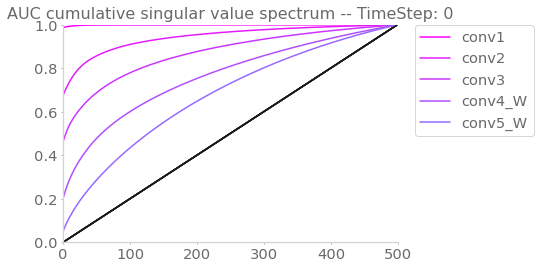

(566, 12864)
using 500 pcs; explaining 100.0% of the variance
(566, 8704)
using 500 pcs; explaining 100.0% of the variance
(566, 8704)
using 500 pcs; explaining 100.0% of the variance
(566, 17408)
using 500 pcs; explaining 98.9% of the variance
(566, 8704)
using 500 pcs; explaining 96.3% of the variance


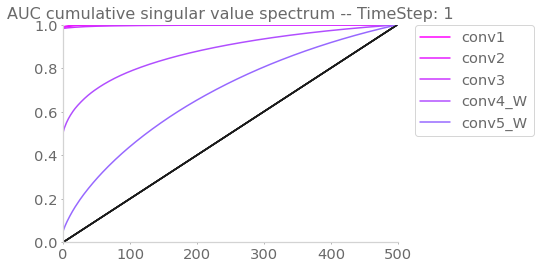

(566, 12864)
using 500 pcs; explaining 100.0% of the variance
(566, 8704)
using 500 pcs; explaining 100.0% of the variance
(566, 8704)
using 500 pcs; explaining 100.0% of the variance
(566, 17408)
using 500 pcs; explaining 99.1% of the variance
(566, 8704)
using 500 pcs; explaining 96.5% of the variance


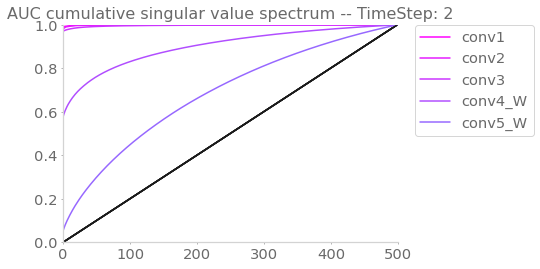

(566, 12864)
using 500 pcs; explaining 100.0% of the variance
(566, 8704)
using 500 pcs; explaining 100.0% of the variance
(566, 8704)
using 500 pcs; explaining 100.0% of the variance
(566, 17408)
using 500 pcs; explaining 99.4% of the variance
(566, 8704)
using 500 pcs; explaining 96.6% of the variance


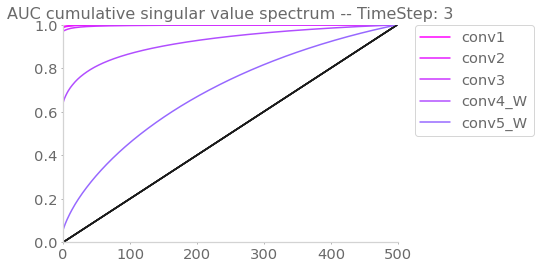

(566, 12864)
using 500 pcs; explaining 100.0% of the variance
(566, 8704)
using 500 pcs; explaining 100.0% of the variance
(566, 8704)
using 500 pcs; explaining 100.0% of the variance
(566, 17408)
using 500 pcs; explaining 99.6% of the variance
(566, 8704)
using 500 pcs; explaining 96.8% of the variance


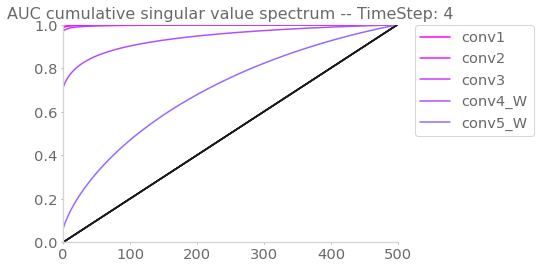

In [99]:
noisy_auc = []

acts_path = '/mnt/smb/locker/abbott-locker/hcnn/activations_pnet_all/'
layers = ['conv1', 'conv2', 'conv3', 'conv4_W', 'conv5_W']
for timestep in range(5):
    noisy_auc.append(plotCumSVS(layers, acts_path + 'Babble8Spkr_snr-9.hdf5',  'AUC cumulative singular value spectrum -- TimeStep: '+str(timestep), timestep))

In [76]:
import configs

(566, 12864)
using 500 pcs; explaining 100.0% of the variance
(566, 8704)
using 500 pcs; explaining 99.7% of the variance
(566, 8704)
using 500 pcs; explaining 98.7% of the variance
(566, 17408)
using 500 pcs; explaining 96.9% of the variance
(566, 8704)
using 500 pcs; explaining 96.2% of the variance


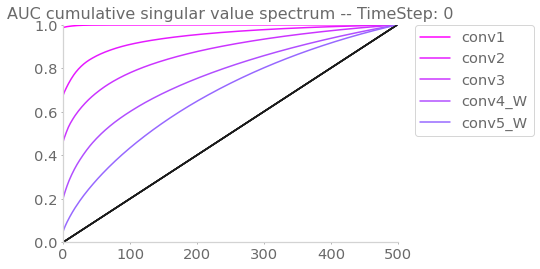

(566, 12864)
using 500 pcs; explaining 100.0% of the variance
(566, 8704)
using 500 pcs; explaining 100.0% of the variance
(566, 8704)
using 500 pcs; explaining 99.9% of the variance
(566, 17408)
using 500 pcs; explaining 98.3% of the variance
(566, 8704)
using 500 pcs; explaining 96.4% of the variance


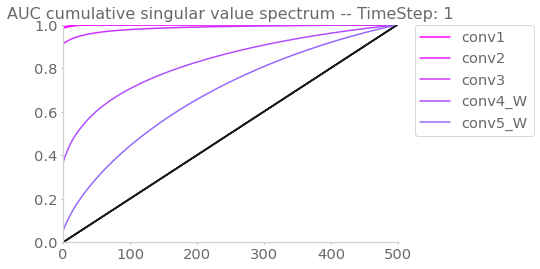

(566, 12864)
using 500 pcs; explaining 100.0% of the variance
(566, 8704)
using 500 pcs; explaining 100.0% of the variance
(566, 8704)
using 500 pcs; explaining 100.0% of the variance
(566, 17408)
using 500 pcs; explaining 98.6% of the variance
(566, 8704)
using 500 pcs; explaining 96.5% of the variance


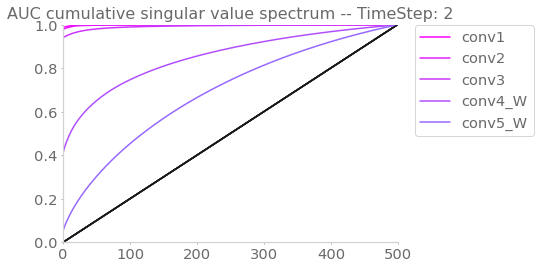

(566, 12864)
using 500 pcs; explaining 100.0% of the variance
(566, 8704)
using 500 pcs; explaining 100.0% of the variance
(566, 8704)
using 500 pcs; explaining 100.0% of the variance
(566, 17408)
using 500 pcs; explaining 98.8% of the variance
(566, 8704)
using 500 pcs; explaining 96.7% of the variance


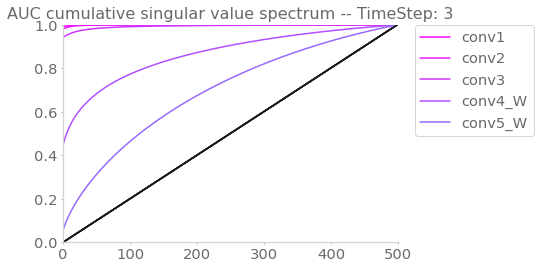

(566, 12864)
using 500 pcs; explaining 100.0% of the variance
(566, 8704)
using 500 pcs; explaining 100.0% of the variance
(566, 8704)
using 500 pcs; explaining 100.0% of the variance
(566, 17408)
using 500 pcs; explaining 99.0% of the variance
(566, 8704)
using 500 pcs; explaining 96.9% of the variance


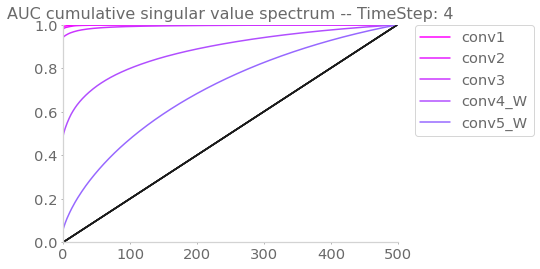

In [274]:
noisy_auc = []

acts_path = '/mnt/smb/locker/abbott-locker/hcnn/activations_random/Babble8Spkr_snr-9/'
layers = ['conv1', 'conv2', 'conv3', 'conv4_W', 'conv5_W']

for timestep in range(5):
    noisy_auc.append(plotCumSVS(layers, acts_path + '208776.3.hdf5',  'AUC cumulative singular value spectrum -- TimeStep: '+str(timestep), timestep))

In [277]:

acts_path = '/mnt/smb/locker/abbott-locker/hcnn/activations_random/Babble8Spkr_snr-9/208776.3.hdf5'
acts_path_2 = '/mnt/smb/locker/abbott-locker/hcnn/activations_random/Babble8Spkr_snr-9/54474.0.hdf5'

In [279]:
with h5py.File(acts_path, 'r') as f_in:
    print(f_in['1_logits'][0:100])

[[ -6.4234295  -8.957336  -11.459651  ... -10.256069  -10.798751
  -10.503194 ]
 [ -8.566001   -9.579184  -10.692903  ...  -9.801299   -9.333839
  -10.408487 ]
 [ -4.24667    -7.663462   -8.122729  ...  -8.08061    -8.51828
   -8.530042 ]
 ...
 [-29.189125  -30.808855  -37.796627  ... -34.319798  -37.018238
  -38.606644 ]
 [ -4.4864197  -8.807814   -8.980973  ...  -7.9032893  -7.34061
   -7.5276103]
 [ -7.0019093 -12.785156  -11.594615  ... -11.409946  -10.985293
  -10.272318 ]]


In [280]:
with h5py.File(acts_path_2, 'r') as f_in:
    print(f_in['1_logits'][0:100])

[[ -6.4276376  -9.075416  -11.60055   ... -10.42008   -10.96858
  -10.617458 ]
 [ -8.509689   -9.631947  -10.731181  ...  -9.87284    -9.378978
  -10.42714  ]
 [ -4.3362784  -7.8747787  -8.347121  ...  -8.302865   -8.734546
   -8.752967 ]
 ...
 [-28.809767  -30.67876   -37.57569   ... -33.97826   -36.795387
  -38.30111  ]
 [ -4.440333   -8.804425   -9.002055  ...  -7.944203   -7.351114
   -7.5646253]
 [ -7.0155168 -12.915328  -11.670716  ... -11.547199  -11.082276
  -10.339375 ]]


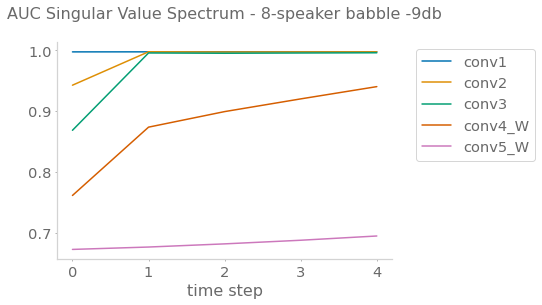

In [100]:
to_plot = np.array(noisy_auc)
for ii in range(5):
    plt.plot(range(len(to_plot[:,ii])), to_plot[:,ii], label = layers[ii])
    
    plt.title('AUC Singular Value Spectrum - 8-speaker babble -9db\n')
    plt.xlabel('time step')
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

In [275]:
clean_auc = []

acts_path = '/mnt/smb/locker/abbott-locker/hcnn/activations_pnet_all/'
layers = ['conv1', 'conv2', 'conv3', 'conv4_W', 'conv5_W']
for timestep in range(5):
    clean_auc.append(plotCumSVS(layers, acts_path + 'Babble8Spkr_snr-9.hdf5',  'AUC cumulative singular value spectrum -- TimeStep: '+str(timestep), timestep,))

OSError: Unable to open file (unable to open file: name = '/mnt/smb/locker/abbott-locker/hcnn/activations_pnet_all/Babble8Spkr_snr-9.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

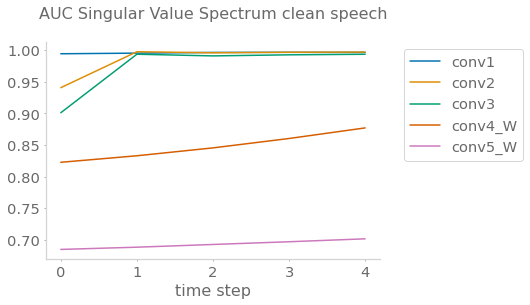

In [85]:
to_plot = np.array(clean_auc)
for ii in range(5):
    plt.plot(range(len(to_plot[:,ii])), to_plot[:,ii], label = layers[ii])
    
    plt.title('AUC Singular Value Spectrum clean speech\n')
    plt.xlabel('time step')
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left') 
    

In [17]:
clean_auc = to_plot_auc

(165, 12864)
using 165 pcs; explaining 100.0% of the variance
(165, 8704)
using 165 pcs; explaining 100.0% of the variance
(165, 8704)
using 165 pcs; explaining 100.0% of the variance
(165, 17408)
using 165 pcs; explaining 100.0% of the variance
(165, 8704)
using 165 pcs; explaining 100.0% of the variance


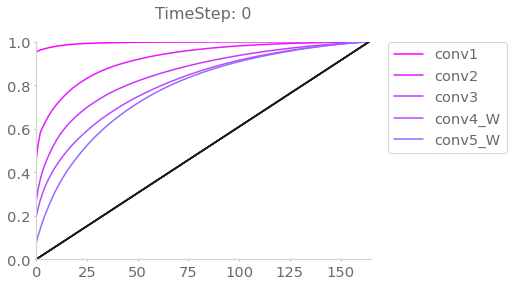

(165, 12864)
using 165 pcs; explaining 100.0% of the variance
(165, 8704)
using 165 pcs; explaining 100.0% of the variance
(165, 8704)
using 165 pcs; explaining 100.0% of the variance
(165, 17408)
using 165 pcs; explaining 100.0% of the variance
(165, 8704)
using 165 pcs; explaining 100.0% of the variance


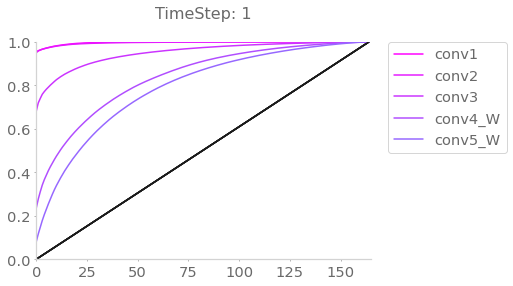

(165, 12864)
using 165 pcs; explaining 100.0% of the variance
(165, 8704)
using 165 pcs; explaining 100.0% of the variance
(165, 8704)
using 165 pcs; explaining 100.0% of the variance
(165, 17408)
using 165 pcs; explaining 100.0% of the variance
(165, 8704)
using 165 pcs; explaining 100.0% of the variance


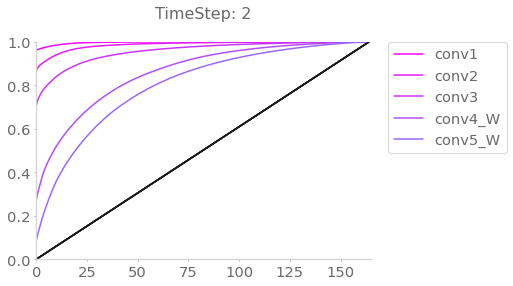

(165, 12864)
using 165 pcs; explaining 100.0% of the variance
(165, 8704)
using 165 pcs; explaining 100.0% of the variance
(165, 8704)
using 165 pcs; explaining 100.0% of the variance
(165, 17408)
using 165 pcs; explaining 100.0% of the variance
(165, 8704)
using 165 pcs; explaining 100.0% of the variance


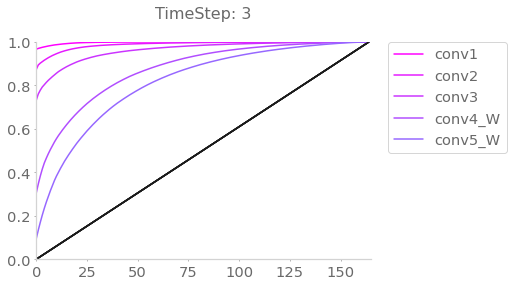

(165, 12864)
using 165 pcs; explaining 100.0% of the variance
(165, 8704)
using 165 pcs; explaining 100.0% of the variance
(165, 8704)
using 165 pcs; explaining 100.0% of the variance
(165, 17408)
using 165 pcs; explaining 100.0% of the variance
(165, 8704)
using 165 pcs; explaining 100.0% of the variance


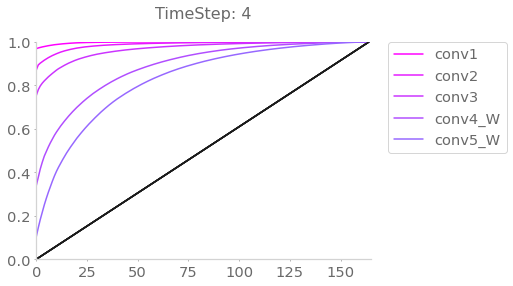

In [55]:
natural_sound_auc = []

acts_path = '/mnt/smb/locker/abbott-locker/hcnn/activations_pnet_all/'
layers = ['conv1', 'conv2', 'conv3', 'conv4_W', 'conv5_W']
for timestep in range(5):
    natural_sound_auc.append(plotCumSVS(layers, acts_path + 'natural_sounds.hdf5',  'TimeStep: '+str(timestep)+ '\n', timestep, num_pcs=165))

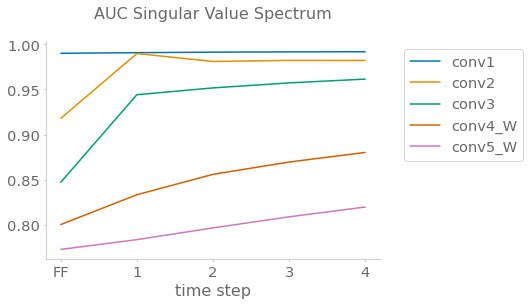

In [92]:
to_plot_auc = np.array(natural_sound_auc)
for ii in range(5):
    plt.plot(range(len(to_plot_auc[:,ii])), to_plot_auc[:,ii], label = layers[ii])
    
    plt.title('AUC Singular Value Spectrum\n')
    plt.xlabel('time step')
    plt.xticks(range(5), ['FF', '1','2','3','4'])
  
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

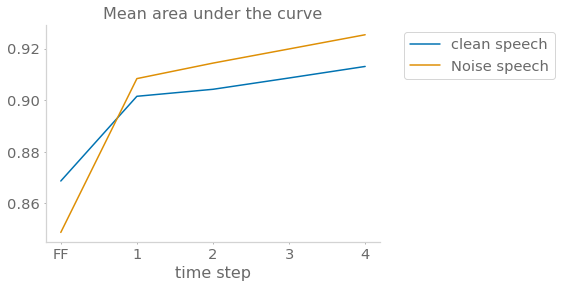

In [107]:
#plt.plot(range(5), np.mean(np.array(natural_sound_auc), axis=1), label = 'natural sounds')
plt.plot(range(5), np.mean(np.array(clean_auc), axis=1), label = 'clean speech')
plt.plot(range(5), np.mean(np.array(noisy_auc), axis=1), label = 'Noise speech')
plt.title('Mean area under the curve')
plt.xlabel('time step')
plt.xticks(range(5), ['FF', '1','2','3','4'])
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')




([<matplotlib.axis.XTick at 0x2b69576b9b00>,
 [Text(0, 0, 'conv1'),
  Text(1, 0, 'conv2'),
  Text(2, 0, 'conv3'),
  Text(3, 0, 'conv4_W'),
  Text(4, 0, 'conv5_W')])

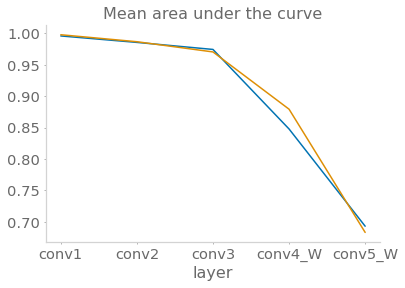

In [109]:
plt.plot(range(len(clean_auc)), np.mean(clean_auc, axis=0))
plt.plot(range(len(noisy_auc)), np.mean(noisy_auc, axis=0))


plt.title('Mean area under the curve')
plt.xlabel('layer')
plt.xticks(range(5), layers)

In [ ]:

def getAUC(layers, act_path, title, timestep, clean = False, num_pcs = 500):
    with h5py.File(act_path, 'r') as f_in:
        to_plot_auc = []
        color_range = range(len(layers))
        for ii, layer in enumerate(layers):
            if clean: 
                activation = timeAverage(f_in[layer+'_'+str(timestep)+'_clean_activations'],  layer)
            else:
                activation = timeAverage(f_in[layer+'_'+str(timestep)+'_activations'],  layer)
            activations_demeaned = (activation - np.mean(activation, axis = 1, keepdims = True))
            print(np.shape(activations_demeaned))
            pcs_net, s_net = runPcaDecomp(activations_demeaned, num_pcs, True)

            x = np.linspace(0, 10)
            colors  = cool(x)[::-1][0:41]
           
            to_plot_auc.append(sklearn.metrics.auc(range(1,num_pcs+1), np.cumsum(s_net**2)/np.sum(s_net**2))/(float(num_pcs)))
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.show()
        return to_plot_auc

In [2]:
import os

In [10]:
acts_path = '/mnt/smb/locker/abbott-locker/hcnn/activations_pnet/v0/'
files = os.listdir(acts_path)
print(files)

['Babble8Spkr_snr-3.hdf5', 'AudScene_snr0.hdf5', 'pinkNoise_snr-9.hdf5', 'Babble8Spkr_snr-9.hdf5', 'natural_sounds.hdf5', 'AudScene_snr-3.hdf5', 'pinkNoise_snr3.hdf5', 'AudScene_snr-6.hdf5', 'Babble8Spkr_snr-6.hdf5', 'pinkNoise_snr-6.hdf5', 'AudScene_snr-9.hdf5', 'pinkNoise_snr0.hdf5', 'Babble8Spkr_snr3.hdf5', 'AudScene_snr3.hdf5', 'pinkNoise_snr-3.hdf5', 'Babble8Spkr_snr0.hdf5']


In [11]:
files.remove('natural_sounds.hdf5')

AudScene_snr-3.hdf5
0
(568, 12864)
using 500 pcs; explaining 100.0% of the variance
(568, 8704)
using 500 pcs; explaining 99.8% of the variance
(568, 8704)
using 500 pcs; explaining 99.2% of the variance
(568, 17408)
using 500 pcs; explaining 98.0% of the variance
(568, 8704)
using 500 pcs; explaining 96.3% of the variance


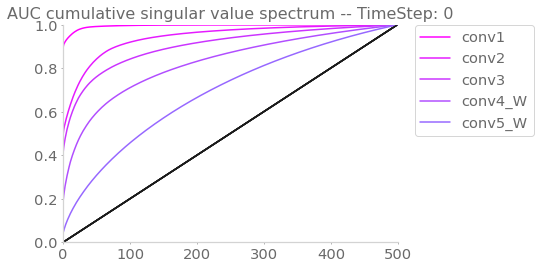

(568, 12864)
using 500 pcs; explaining 100.0% of the variance
(568, 8704)
using 500 pcs; explaining 99.8% of the variance
(568, 8704)
using 500 pcs; explaining 98.8% of the variance
(568, 17408)
using 500 pcs; explaining 97.7% of the variance
(568, 8704)
using 500 pcs; explaining 97.2% of the variance


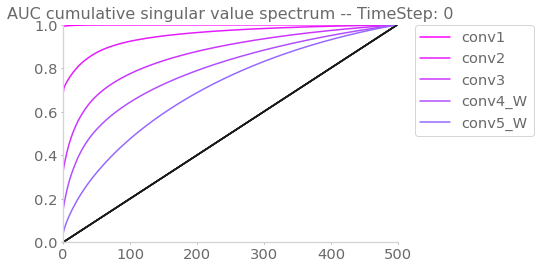

1
(568, 12864)
using 500 pcs; explaining 100.0% of the variance
(568, 8704)
using 500 pcs; explaining 100.0% of the variance
(568, 8704)
using 500 pcs; explaining 99.6% of the variance
(568, 17408)
using 500 pcs; explaining 98.1% of the variance
(568, 8704)
using 500 pcs; explaining 96.4% of the variance


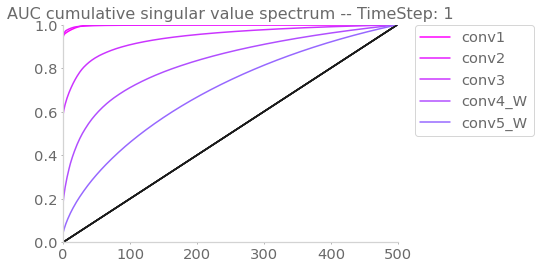

(568, 12864)
using 500 pcs; explaining 100.0% of the variance
(568, 8704)
using 500 pcs; explaining 100.0% of the variance
(568, 8704)
using 500 pcs; explaining 99.5% of the variance
(568, 17408)
using 500 pcs; explaining 98.2% of the variance
(568, 8704)
using 500 pcs; explaining 97.3% of the variance


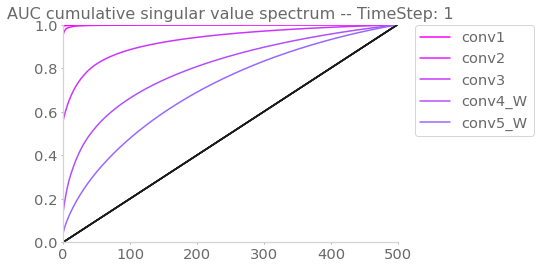

2
(568, 12864)
using 500 pcs; explaining 100.0% of the variance
(568, 8704)
using 500 pcs; explaining 100.0% of the variance
(568, 8704)
using 500 pcs; explaining 99.8% of the variance
(568, 17408)
using 500 pcs; explaining 98.2% of the variance
(568, 8704)
using 500 pcs; explaining 96.4% of the variance


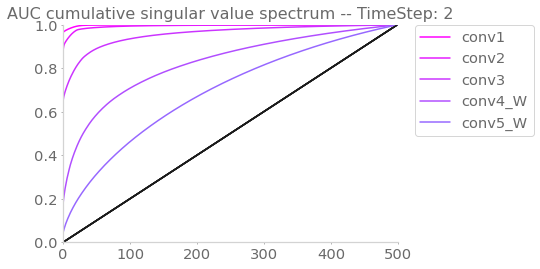

(568, 12864)
using 500 pcs; explaining 100.0% of the variance
(568, 8704)
using 500 pcs; explaining 100.0% of the variance
(568, 8704)
using 500 pcs; explaining 99.7% of the variance
(568, 17408)
using 500 pcs; explaining 98.4% of the variance
(568, 8704)
using 500 pcs; explaining 97.3% of the variance


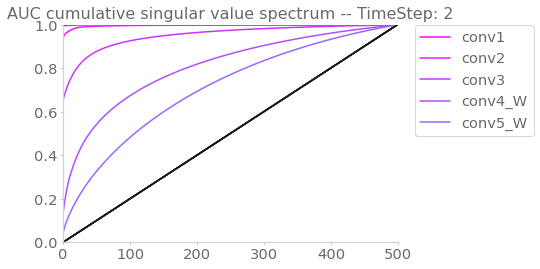

3
(568, 12864)
using 500 pcs; explaining 100.0% of the variance
(568, 8704)
using 500 pcs; explaining 100.0% of the variance
(568, 8704)
using 500 pcs; explaining 99.8% of the variance
(568, 17408)
using 500 pcs; explaining 98.2% of the variance
(568, 8704)
using 500 pcs; explaining 96.5% of the variance


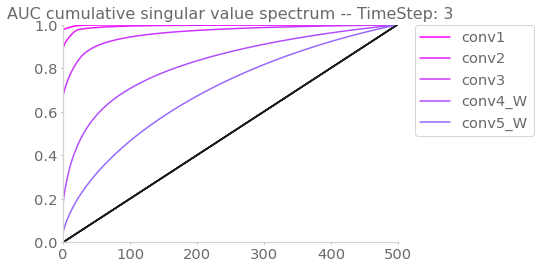

(568, 12864)
using 500 pcs; explaining 100.0% of the variance
(568, 8704)
using 500 pcs; explaining 100.0% of the variance
(568, 8704)
using 500 pcs; explaining 99.8% of the variance
(568, 17408)
using 500 pcs; explaining 98.6% of the variance
(568, 8704)
using 500 pcs; explaining 97.4% of the variance


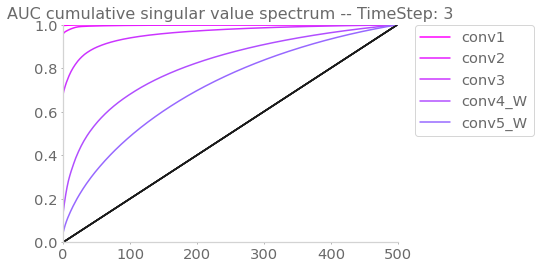

4
(568, 12864)
using 500 pcs; explaining 100.0% of the variance
(568, 8704)
using 500 pcs; explaining 100.0% of the variance
(568, 8704)
using 500 pcs; explaining 99.8% of the variance
(568, 17408)
using 500 pcs; explaining 98.2% of the variance
(568, 8704)
using 500 pcs; explaining 96.5% of the variance


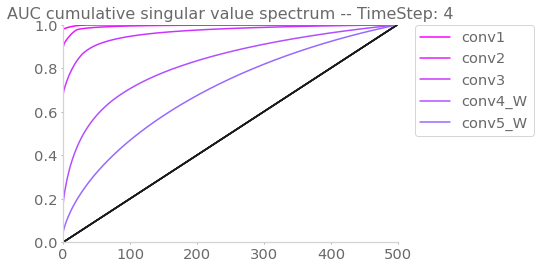

(568, 12864)
using 500 pcs; explaining 100.0% of the variance
(568, 8704)
using 500 pcs; explaining 100.0% of the variance
(568, 8704)
using 500 pcs; explaining 99.8% of the variance
(568, 17408)
using 500 pcs; explaining 98.7% of the variance
(568, 8704)
using 500 pcs; explaining 97.5% of the variance


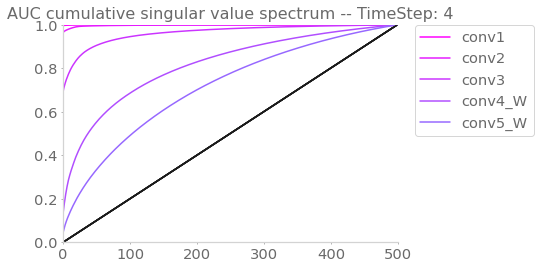

pinkNoise_snr3.hdf5
0
(526, 12864)
using 500 pcs; explaining 100.0% of the variance
(526, 8704)
using 500 pcs; explaining 99.9% of the variance
(526, 8704)
using 500 pcs; explaining 99.7% of the variance
(526, 17408)
using 500 pcs; explaining 99.2% of the variance
(526, 8704)
using 500 pcs; explaining 98.7% of the variance


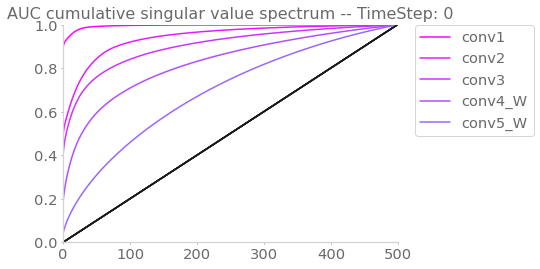

(526, 12864)
using 500 pcs; explaining 100.0% of the variance
(526, 8704)
using 500 pcs; explaining 99.9% of the variance
(526, 8704)
using 500 pcs; explaining 99.7% of the variance
(526, 17408)
using 500 pcs; explaining 99.4% of the variance
(526, 8704)
using 500 pcs; explaining 99.2% of the variance


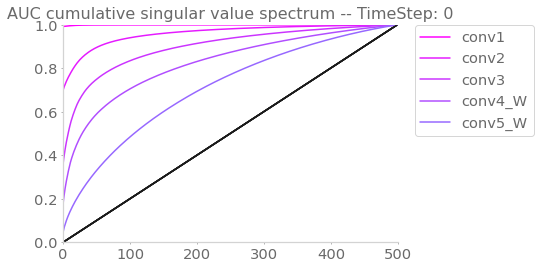

1
(526, 12864)
using 500 pcs; explaining 100.0% of the variance
(526, 8704)
using 500 pcs; explaining 100.0% of the variance
(526, 8704)
using 500 pcs; explaining 99.9% of the variance
(526, 17408)
using 500 pcs; explaining 99.3% of the variance
(526, 8704)
using 500 pcs; explaining 98.7% of the variance


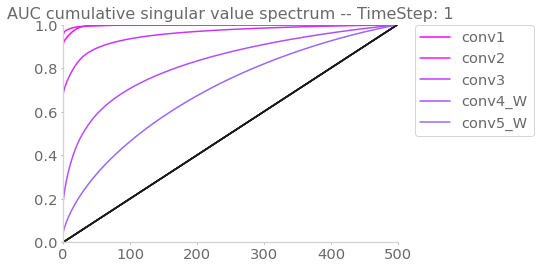

(526, 12864)
using 500 pcs; explaining 100.0% of the variance
(526, 8704)
using 500 pcs; explaining 100.0% of the variance
(526, 8704)
using 500 pcs; explaining 99.9% of the variance
(526, 17408)
using 500 pcs; explaining 99.5% of the variance
(526, 8704)
using 500 pcs; explaining 99.2% of the variance


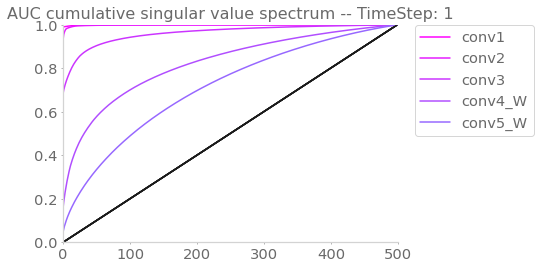

2
(526, 12864)
using 500 pcs; explaining 100.0% of the variance
(526, 8704)
using 500 pcs; explaining 100.0% of the variance
(526, 8704)
using 500 pcs; explaining 99.9% of the variance
(526, 17408)
using 500 pcs; explaining 99.3% of the variance
(526, 8704)
using 500 pcs; explaining 98.7% of the variance


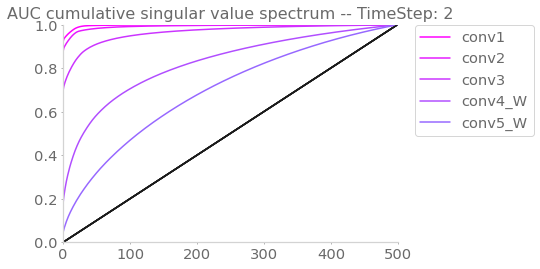

(526, 12864)
using 500 pcs; explaining 100.0% of the variance
(526, 8704)
using 500 pcs; explaining 100.0% of the variance
(526, 8704)
using 500 pcs; explaining 99.9% of the variance
(526, 17408)
using 500 pcs; explaining 99.6% of the variance
(526, 8704)
using 500 pcs; explaining 99.2% of the variance


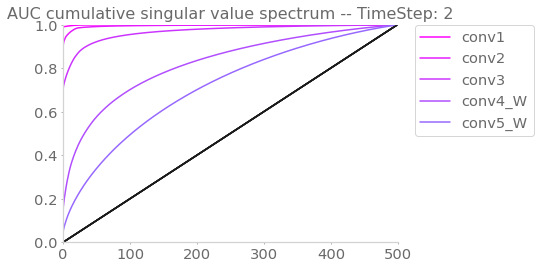

3
(526, 12864)
using 500 pcs; explaining 100.0% of the variance
(526, 8704)
using 500 pcs; explaining 100.0% of the variance
(526, 8704)
using 500 pcs; explaining 99.9% of the variance
(526, 17408)
using 500 pcs; explaining 99.3% of the variance
(526, 8704)
using 500 pcs; explaining 98.7% of the variance


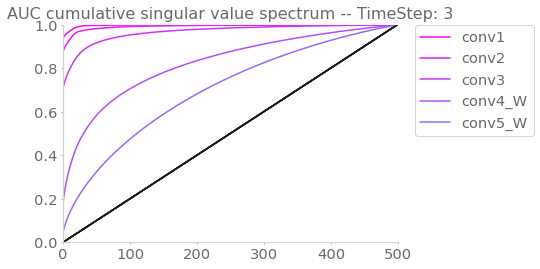

(526, 12864)
using 500 pcs; explaining 100.0% of the variance
(526, 8704)
using 500 pcs; explaining 100.0% of the variance
(526, 8704)
using 500 pcs; explaining 100.0% of the variance
(526, 17408)
using 500 pcs; explaining 99.6% of the variance
(526, 8704)
using 500 pcs; explaining 99.3% of the variance


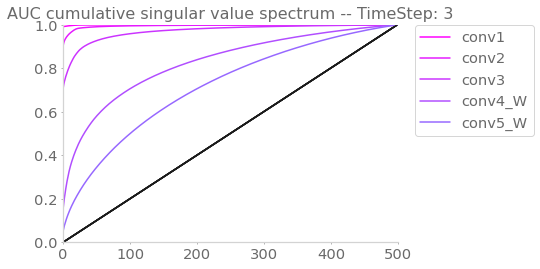

4
(526, 12864)
using 500 pcs; explaining 100.0% of the variance
(526, 8704)
using 500 pcs; explaining 100.0% of the variance
(526, 8704)
using 500 pcs; explaining 99.9% of the variance
(526, 17408)
using 500 pcs; explaining 99.3% of the variance
(526, 8704)
using 500 pcs; explaining 98.8% of the variance


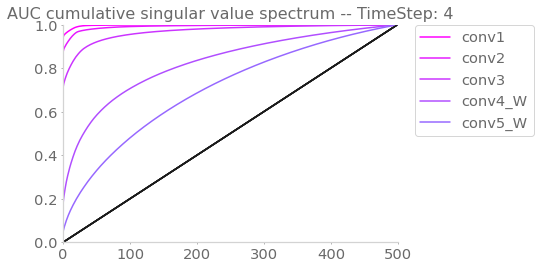

(526, 12864)
using 500 pcs; explaining 100.0% of the variance
(526, 8704)
using 500 pcs; explaining 100.0% of the variance
(526, 8704)
using 500 pcs; explaining 100.0% of the variance
(526, 17408)
using 500 pcs; explaining 99.7% of the variance
(526, 8704)
using 500 pcs; explaining 99.3% of the variance


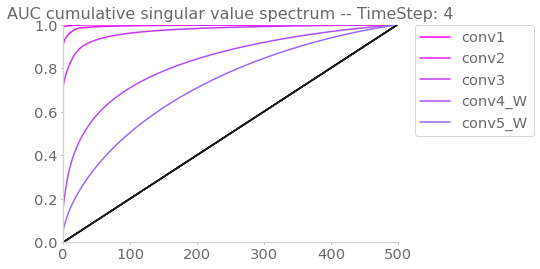

AudScene_snr-6.hdf5
0
(569, 12864)
using 500 pcs; explaining 100.0% of the variance
(569, 8704)
using 500 pcs; explaining 99.8% of the variance
(569, 8704)
using 500 pcs; explaining 99.2% of the variance
(569, 17408)
using 500 pcs; explaining 98.0% of the variance
(569, 8704)
using 500 pcs; explaining 96.3% of the variance


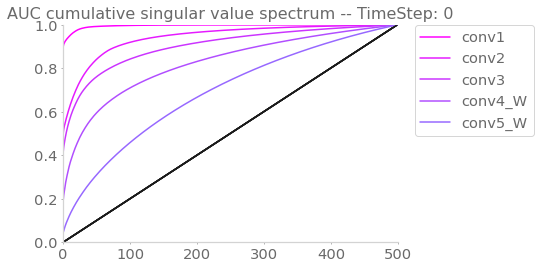

(569, 12864)
using 500 pcs; explaining 100.0% of the variance
(569, 8704)
using 500 pcs; explaining 99.8% of the variance
(569, 8704)
using 500 pcs; explaining 98.9% of the variance
(569, 17408)
using 500 pcs; explaining 97.7% of the variance
(569, 8704)
using 500 pcs; explaining 97.4% of the variance


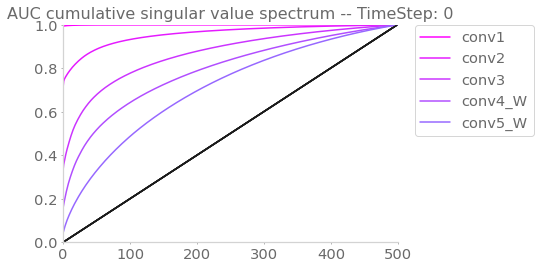

1
(569, 12864)
using 500 pcs; explaining 100.0% of the variance
(569, 8704)
using 500 pcs; explaining 100.0% of the variance
(569, 8704)
using 500 pcs; explaining 99.7% of the variance
(569, 17408)
using 500 pcs; explaining 98.1% of the variance
(569, 8704)
using 500 pcs; explaining 96.3% of the variance


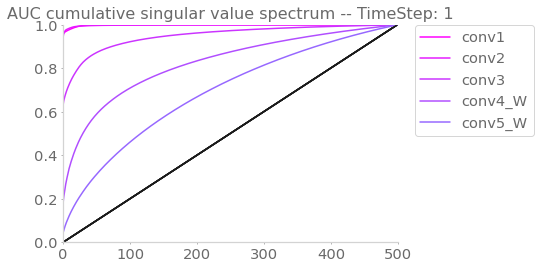

(569, 12864)
using 500 pcs; explaining 100.0% of the variance
(569, 8704)
using 500 pcs; explaining 100.0% of the variance
(569, 8704)
using 500 pcs; explaining 99.6% of the variance
(569, 17408)
using 500 pcs; explaining 98.2% of the variance
(569, 8704)
using 500 pcs; explaining 97.4% of the variance


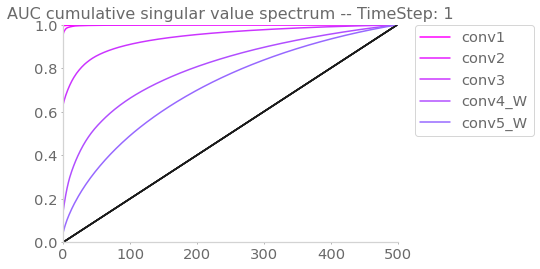

2
(569, 12864)
using 500 pcs; explaining 100.0% of the variance
(569, 8704)
using 500 pcs; explaining 100.0% of the variance
(569, 8704)
using 500 pcs; explaining 99.8% of the variance
(569, 17408)
using 500 pcs; explaining 98.2% of the variance
(569, 8704)
using 500 pcs; explaining 96.4% of the variance


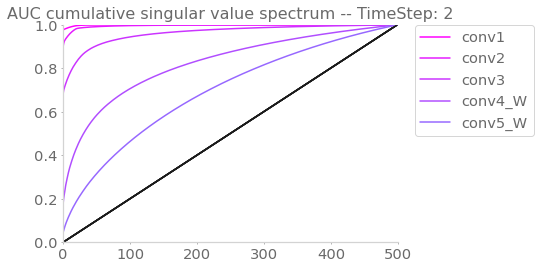

(569, 12864)
using 500 pcs; explaining 100.0% of the variance
(569, 8704)
using 500 pcs; explaining 100.0% of the variance
(569, 8704)
using 500 pcs; explaining 99.8% of the variance
(569, 17408)
using 500 pcs; explaining 98.5% of the variance
(569, 8704)
using 500 pcs; explaining 97.5% of the variance


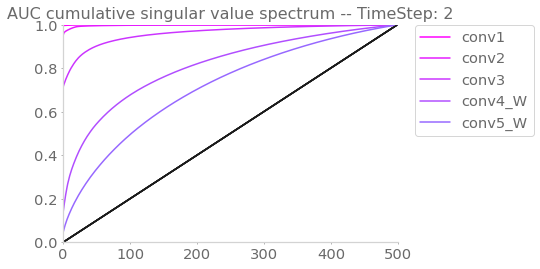

3
(569, 12864)
using 500 pcs; explaining 100.0% of the variance
(569, 8704)
using 500 pcs; explaining 100.0% of the variance
(569, 8704)
using 500 pcs; explaining 99.8% of the variance
(569, 17408)
using 500 pcs; explaining 98.2% of the variance
(569, 8704)
using 500 pcs; explaining 96.4% of the variance


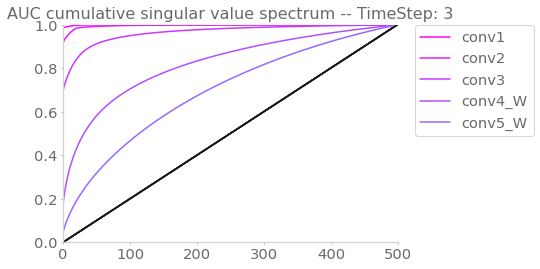

(569, 12864)
using 500 pcs; explaining 100.0% of the variance
(569, 8704)
using 500 pcs; explaining 100.0% of the variance
(569, 8704)
using 500 pcs; explaining 99.8% of the variance
(569, 17408)
using 500 pcs; explaining 98.6% of the variance
(569, 8704)
using 500 pcs; explaining 97.6% of the variance


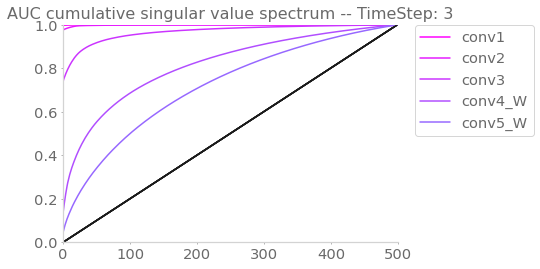

4
(569, 12864)
using 500 pcs; explaining 100.0% of the variance
(569, 8704)
using 500 pcs; explaining 100.0% of the variance
(569, 8704)
using 500 pcs; explaining 99.8% of the variance
(569, 17408)
using 500 pcs; explaining 98.2% of the variance
(569, 8704)
using 500 pcs; explaining 96.5% of the variance


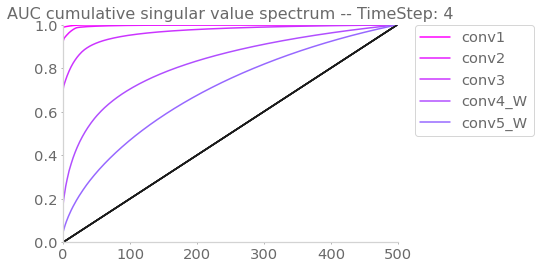

(569, 12864)
using 500 pcs; explaining 100.0% of the variance
(569, 8704)
using 500 pcs; explaining 100.0% of the variance
(569, 8704)
using 500 pcs; explaining 99.9% of the variance
(569, 17408)
using 500 pcs; explaining 98.7% of the variance
(569, 8704)
using 500 pcs; explaining 97.7% of the variance


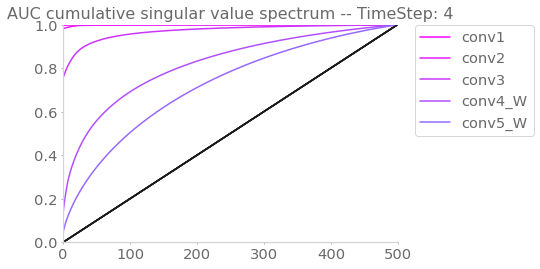

Babble8Spkr_snr-6.hdf5
0
(558, 12864)
using 500 pcs; explaining 100.0% of the variance
(558, 8704)
using 500 pcs; explaining 99.8% of the variance
(558, 8704)
using 500 pcs; explaining 99.3% of the variance
(558, 17408)
using 500 pcs; explaining 98.3% of the variance
(558, 8704)
using 500 pcs; explaining 96.9% of the variance


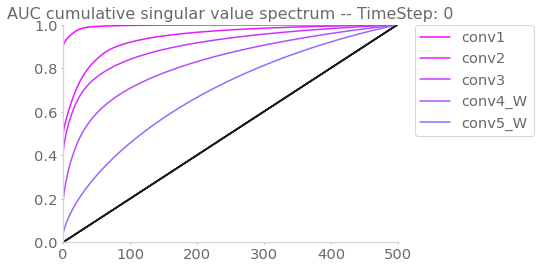

(558, 12864)
using 500 pcs; explaining 100.0% of the variance
(558, 8704)
using 500 pcs; explaining 99.7% of the variance
(558, 8704)
using 500 pcs; explaining 98.9% of the variance
(558, 17408)
using 500 pcs; explaining 97.3% of the variance
(558, 8704)
using 500 pcs; explaining 96.8% of the variance


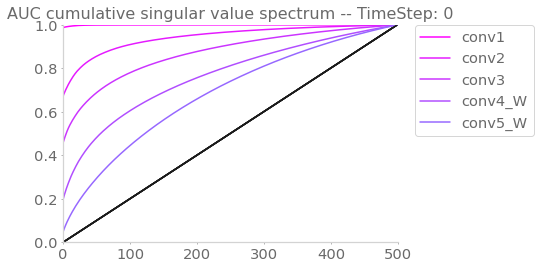

1
(558, 12864)
using 500 pcs; explaining 100.0% of the variance
(558, 8704)
using 500 pcs; explaining 100.0% of the variance
(558, 8704)
using 500 pcs; explaining 99.9% of the variance
(558, 17408)
using 500 pcs; explaining 98.3% of the variance
(558, 8704)
using 500 pcs; explaining 96.9% of the variance


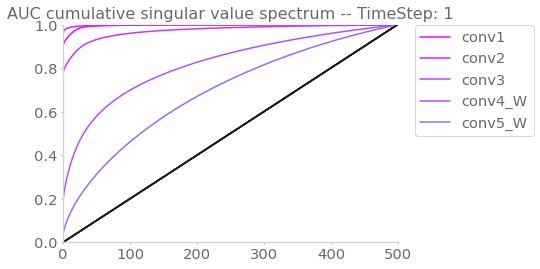

(558, 12864)
using 500 pcs; explaining 100.0% of the variance
(558, 8704)
using 500 pcs; explaining 100.0% of the variance
(558, 8704)
using 500 pcs; explaining 99.9% of the variance
(558, 17408)
using 500 pcs; explaining 97.8% of the variance
(558, 8704)
using 500 pcs; explaining 96.9% of the variance


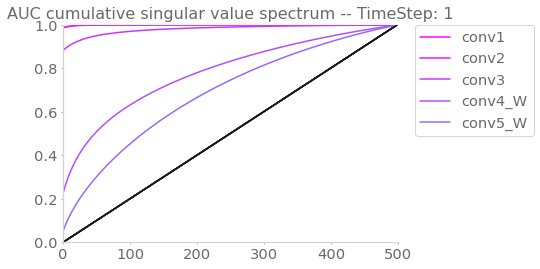

2
(558, 12864)
using 500 pcs; explaining 100.0% of the variance
(558, 8704)
using 500 pcs; explaining 100.0% of the variance
(558, 8704)
using 500 pcs; explaining 99.9% of the variance
(558, 17408)
using 500 pcs; explaining 98.4% of the variance
(558, 8704)
using 500 pcs; explaining 97.0% of the variance


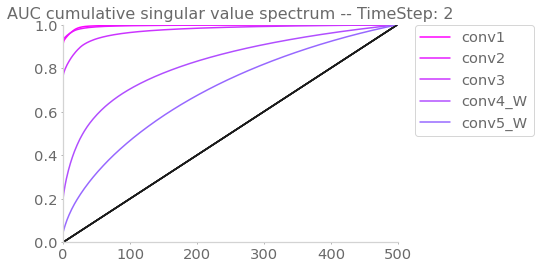

(558, 12864)
using 500 pcs; explaining 100.0% of the variance
(558, 8704)
using 500 pcs; explaining 100.0% of the variance
(558, 8704)
using 500 pcs; explaining 99.9% of the variance
(558, 17408)
using 500 pcs; explaining 98.1% of the variance
(558, 8704)
using 500 pcs; explaining 97.0% of the variance


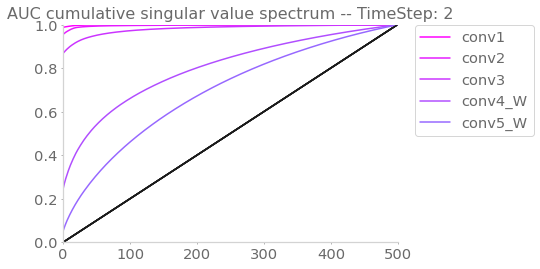

3
(558, 12864)
using 500 pcs; explaining 100.0% of the variance
(558, 8704)
using 500 pcs; explaining 100.0% of the variance
(558, 8704)
using 500 pcs; explaining 99.9% of the variance
(558, 17408)
using 500 pcs; explaining 98.5% of the variance
(558, 8704)
using 500 pcs; explaining 97.1% of the variance


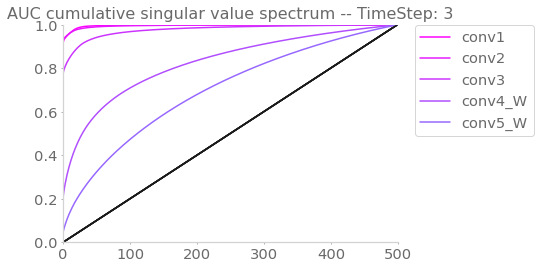

(558, 12864)
using 500 pcs; explaining 100.0% of the variance
(558, 8704)
using 500 pcs; explaining 100.0% of the variance
(558, 8704)
using 500 pcs; explaining 99.9% of the variance
(558, 17408)
using 500 pcs; explaining 98.3% of the variance
(558, 8704)
using 500 pcs; explaining 97.2% of the variance


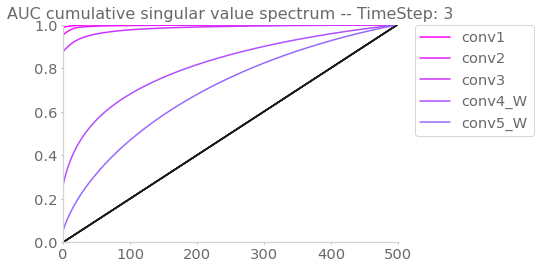

4
(558, 12864)
using 500 pcs; explaining 100.0% of the variance
(558, 8704)
using 500 pcs; explaining 100.0% of the variance
(558, 8704)
using 500 pcs; explaining 99.9% of the variance
(558, 17408)
using 500 pcs; explaining 98.5% of the variance
(558, 8704)
using 500 pcs; explaining 97.1% of the variance


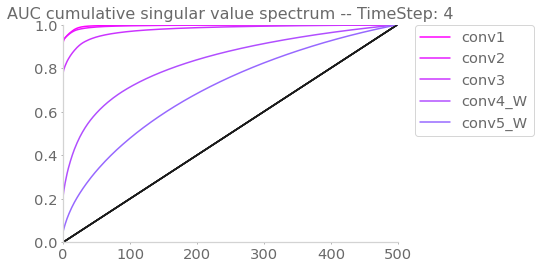

(558, 12864)
using 500 pcs; explaining 100.0% of the variance
(558, 8704)
using 500 pcs; explaining 100.0% of the variance
(558, 8704)
using 500 pcs; explaining 99.9% of the variance
(558, 17408)
using 500 pcs; explaining 98.5% of the variance
(558, 8704)
using 500 pcs; explaining 97.3% of the variance


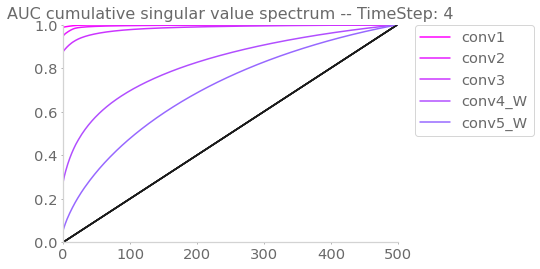

pinkNoise_snr-6.hdf5
0
(526, 12864)
using 500 pcs; explaining 100.0% of the variance
(526, 8704)
using 500 pcs; explaining 99.9% of the variance
(526, 8704)
using 500 pcs; explaining 99.7% of the variance
(526, 17408)
using 500 pcs; explaining 99.2% of the variance
(526, 8704)
using 500 pcs; explaining 98.7% of the variance


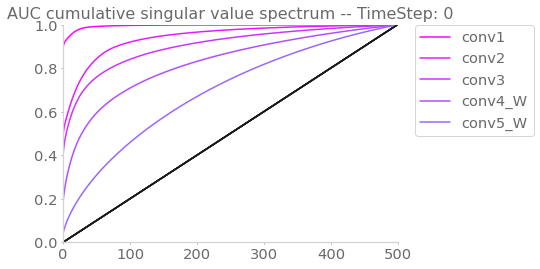

(526, 12864)
using 500 pcs; explaining 100.0% of the variance
(526, 8704)
using 500 pcs; explaining 100.0% of the variance
(526, 8704)
using 500 pcs; explaining 99.8% of the variance
(526, 17408)
using 500 pcs; explaining 99.6% of the variance
(526, 8704)
using 500 pcs; explaining 99.5% of the variance


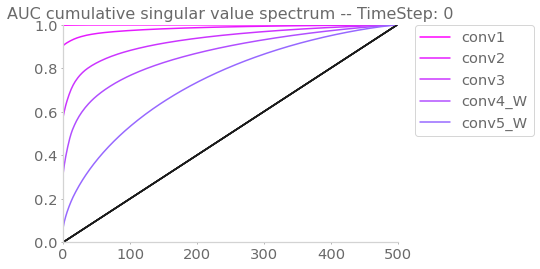

1
(526, 12864)
using 500 pcs; explaining 100.0% of the variance
(526, 8704)
using 500 pcs; explaining 100.0% of the variance
(526, 8704)
using 500 pcs; explaining 99.9% of the variance
(526, 17408)
using 500 pcs; explaining 99.3% of the variance
(526, 8704)
using 500 pcs; explaining 98.7% of the variance


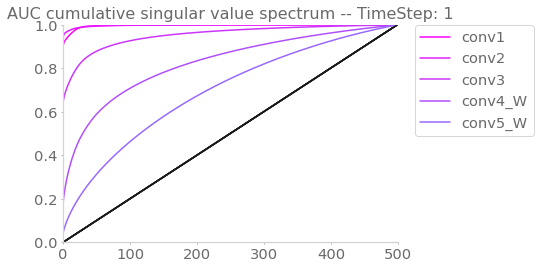

(526, 12864)
using 500 pcs; explaining 100.0% of the variance
(526, 8704)
using 500 pcs; explaining 100.0% of the variance
(526, 8704)
using 500 pcs; explaining 99.9% of the variance
(526, 17408)
using 500 pcs; explaining 99.8% of the variance
(526, 8704)
using 500 pcs; explaining 99.6% of the variance


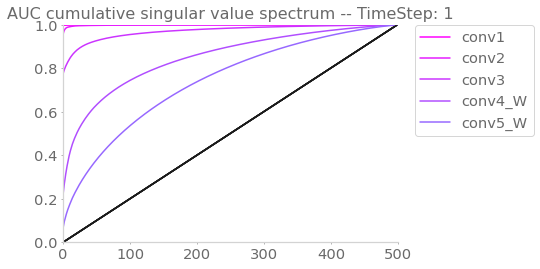

2
(526, 12864)
using 500 pcs; explaining 100.0% of the variance
(526, 8704)
using 500 pcs; explaining 100.0% of the variance
(526, 8704)
using 500 pcs; explaining 99.9% of the variance
(526, 17408)
using 500 pcs; explaining 99.3% of the variance
(526, 8704)
using 500 pcs; explaining 98.7% of the variance


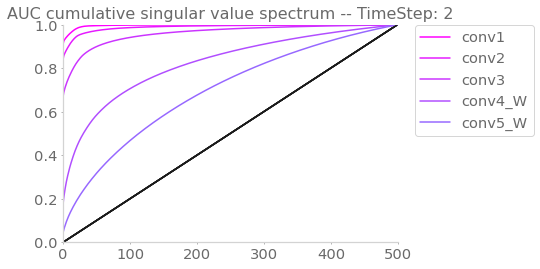

(526, 12864)
using 500 pcs; explaining 100.0% of the variance
(526, 8704)
using 500 pcs; explaining 100.0% of the variance
(526, 8704)
using 500 pcs; explaining 100.0% of the variance
(526, 17408)
using 500 pcs; explaining 99.8% of the variance
(526, 8704)
using 500 pcs; explaining 99.6% of the variance


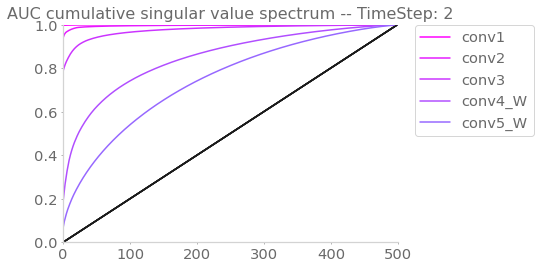

3
(526, 12864)
using 500 pcs; explaining 100.0% of the variance
(526, 8704)
using 500 pcs; explaining 100.0% of the variance
(526, 8704)
using 500 pcs; explaining 99.9% of the variance
(526, 17408)
using 500 pcs; explaining 99.3% of the variance
(526, 8704)
using 500 pcs; explaining 98.7% of the variance


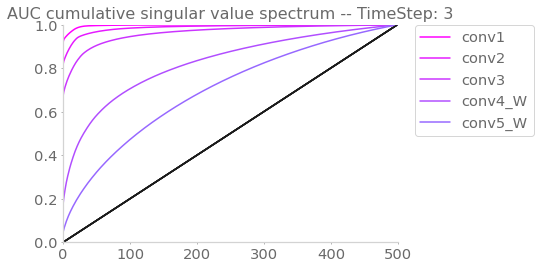

(526, 12864)
using 500 pcs; explaining 100.0% of the variance
(526, 8704)
using 500 pcs; explaining 100.0% of the variance
(526, 8704)
using 500 pcs; explaining 100.0% of the variance
(526, 17408)
using 500 pcs; explaining 99.9% of the variance
(526, 8704)
using 500 pcs; explaining 99.6% of the variance


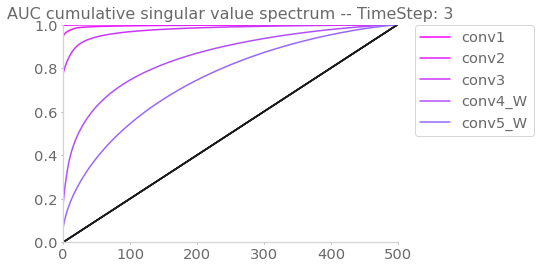

4
(526, 12864)
using 500 pcs; explaining 100.0% of the variance
(526, 8704)
using 500 pcs; explaining 100.0% of the variance
(526, 8704)
using 500 pcs; explaining 99.9% of the variance
(526, 17408)
using 500 pcs; explaining 99.3% of the variance
(526, 8704)
using 500 pcs; explaining 98.7% of the variance


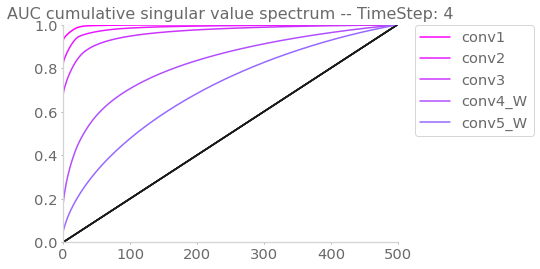

(526, 12864)
using 500 pcs; explaining 100.0% of the variance
(526, 8704)
using 500 pcs; explaining 100.0% of the variance
(526, 8704)
using 500 pcs; explaining 100.0% of the variance
(526, 17408)
using 500 pcs; explaining 99.9% of the variance
(526, 8704)
using 500 pcs; explaining 99.7% of the variance


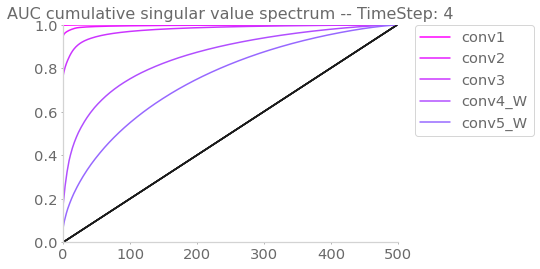

AudScene_snr-9.hdf5
0
(563, 12864)
using 500 pcs; explaining 100.0% of the variance
(563, 8704)
using 500 pcs; explaining 99.8% of the variance
(563, 8704)
using 500 pcs; explaining 99.3% of the variance
(563, 17408)
using 500 pcs; explaining 98.1% of the variance
(563, 8704)
using 500 pcs; explaining 96.6% of the variance


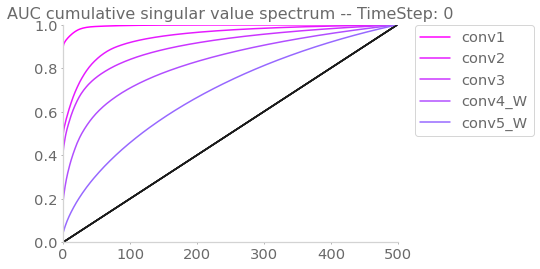

(563, 12864)
using 500 pcs; explaining 100.0% of the variance
(563, 8704)
using 500 pcs; explaining 99.8% of the variance
(563, 8704)
using 500 pcs; explaining 99.0% of the variance
(563, 17408)
using 500 pcs; explaining 98.0% of the variance
(563, 8704)
using 500 pcs; explaining 97.7% of the variance


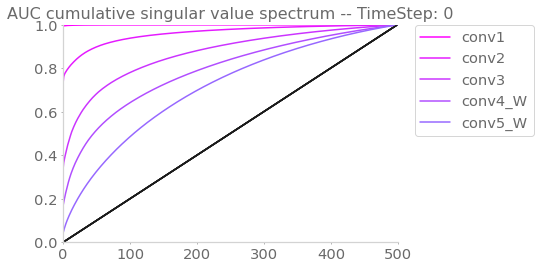

1
(563, 12864)
using 500 pcs; explaining 100.0% of the variance
(563, 8704)
using 500 pcs; explaining 100.0% of the variance
(563, 8704)
using 500 pcs; explaining 99.8% of the variance
(563, 17408)
using 500 pcs; explaining 98.2% of the variance
(563, 8704)
using 500 pcs; explaining 96.6% of the variance


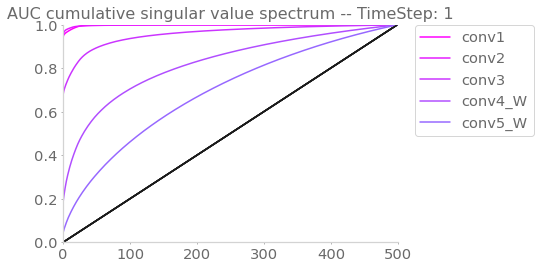

(563, 12864)
using 500 pcs; explaining 100.0% of the variance
(563, 8704)
using 500 pcs; explaining 100.0% of the variance
(563, 8704)
using 500 pcs; explaining 99.8% of the variance
(563, 17408)
using 500 pcs; explaining 98.6% of the variance
(563, 8704)
using 500 pcs; explaining 97.8% of the variance


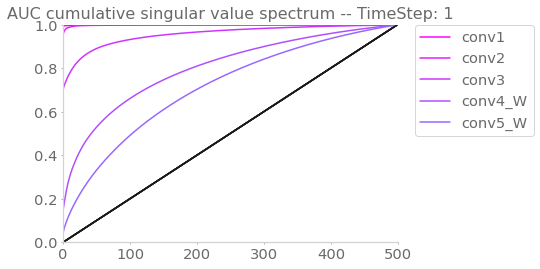

2
(563, 12864)
using 500 pcs; explaining 100.0% of the variance
(563, 8704)
using 500 pcs; explaining 100.0% of the variance
(563, 8704)
using 500 pcs; explaining 99.8% of the variance
(563, 17408)
using 500 pcs; explaining 98.3% of the variance
(563, 8704)
using 500 pcs; explaining 96.6% of the variance


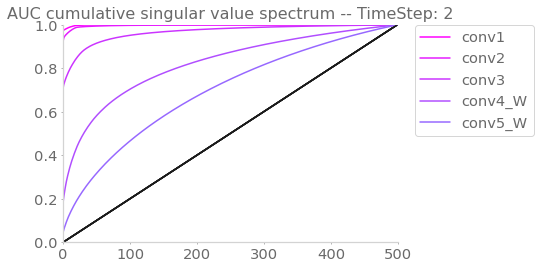

(563, 12864)
using 500 pcs; explaining 100.0% of the variance
(563, 8704)
using 500 pcs; explaining 100.0% of the variance
(563, 8704)
using 500 pcs; explaining 99.9% of the variance
(563, 17408)
using 500 pcs; explaining 98.9% of the variance
(563, 8704)
using 500 pcs; explaining 97.9% of the variance


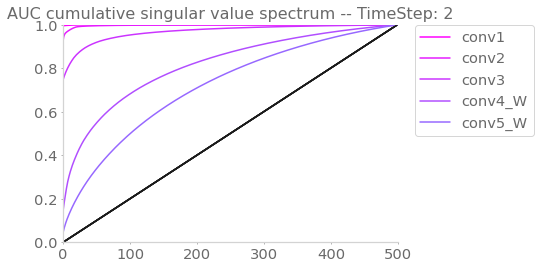

3
(563, 12864)
using 500 pcs; explaining 100.0% of the variance
(563, 8704)
using 500 pcs; explaining 100.0% of the variance
(563, 8704)
using 500 pcs; explaining 99.9% of the variance
(563, 17408)
using 500 pcs; explaining 98.3% of the variance
(563, 8704)
using 500 pcs; explaining 96.7% of the variance


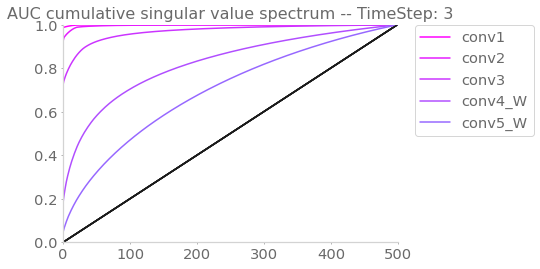

(563, 12864)
using 500 pcs; explaining 100.0% of the variance
(563, 8704)
using 500 pcs; explaining 100.0% of the variance
(563, 8704)
using 500 pcs; explaining 99.9% of the variance
(563, 17408)
using 500 pcs; explaining 99.0% of the variance
(563, 8704)
using 500 pcs; explaining 98.0% of the variance


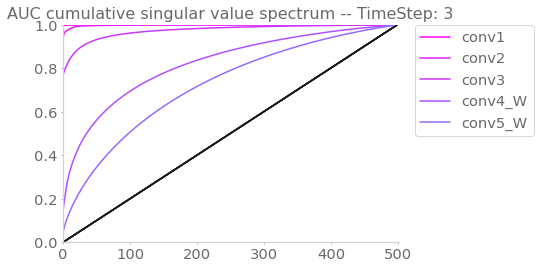

4
(563, 12864)
using 500 pcs; explaining 100.0% of the variance
(563, 8704)
using 500 pcs; explaining 100.0% of the variance
(563, 8704)
using 500 pcs; explaining 99.9% of the variance
(563, 17408)
using 500 pcs; explaining 98.3% of the variance
(563, 8704)
using 500 pcs; explaining 96.7% of the variance


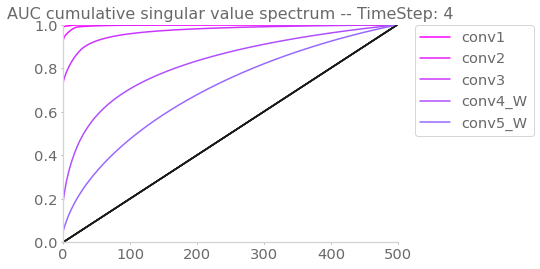

(563, 12864)
using 500 pcs; explaining 100.0% of the variance
(563, 8704)
using 500 pcs; explaining 100.0% of the variance
(563, 8704)
using 500 pcs; explaining 99.9% of the variance
(563, 17408)
using 500 pcs; explaining 99.1% of the variance
(563, 8704)
using 500 pcs; explaining 98.1% of the variance


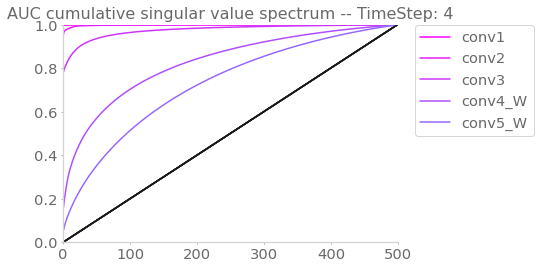

pinkNoise_snr0.hdf5
0
(526, 12864)
using 500 pcs; explaining 100.0% of the variance
(526, 8704)
using 500 pcs; explaining 99.9% of the variance
(526, 8704)
using 500 pcs; explaining 99.7% of the variance
(526, 17408)
using 500 pcs; explaining 99.2% of the variance
(526, 8704)
using 500 pcs; explaining 98.7% of the variance


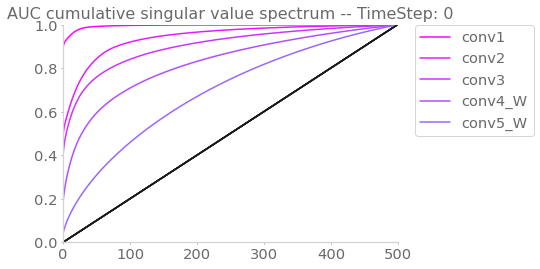

(526, 12864)
using 500 pcs; explaining 100.0% of the variance
(526, 8704)
using 500 pcs; explaining 99.9% of the variance
(526, 8704)
using 500 pcs; explaining 99.7% of the variance
(526, 17408)
using 500 pcs; explaining 99.5% of the variance
(526, 8704)
using 500 pcs; explaining 99.3% of the variance


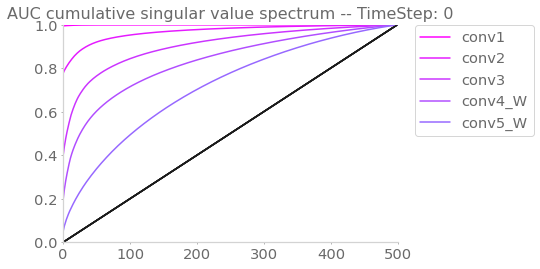

1
(526, 12864)
using 500 pcs; explaining 100.0% of the variance
(526, 8704)
using 500 pcs; explaining 100.0% of the variance
(526, 8704)
using 500 pcs; explaining 99.9% of the variance
(526, 17408)
using 500 pcs; explaining 99.3% of the variance
(526, 8704)
using 500 pcs; explaining 98.7% of the variance


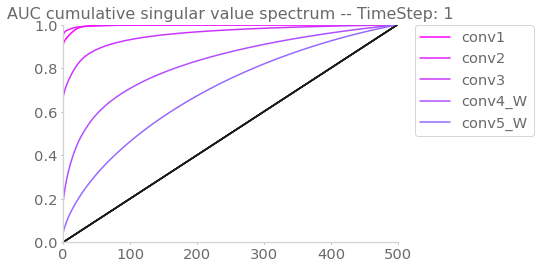

(526, 12864)
using 500 pcs; explaining 100.0% of the variance
(526, 8704)
using 500 pcs; explaining 100.0% of the variance
(526, 8704)
using 500 pcs; explaining 99.9% of the variance
(526, 17408)
using 500 pcs; explaining 99.6% of the variance
(526, 8704)
using 500 pcs; explaining 99.3% of the variance


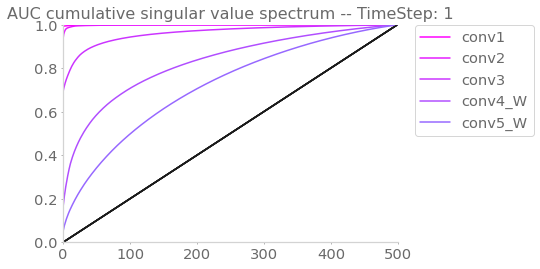

2
(526, 12864)
using 500 pcs; explaining 100.0% of the variance
(526, 8704)
using 500 pcs; explaining 100.0% of the variance
(526, 8704)
using 500 pcs; explaining 99.9% of the variance
(526, 17408)
using 500 pcs; explaining 99.3% of the variance
(526, 8704)
using 500 pcs; explaining 98.7% of the variance


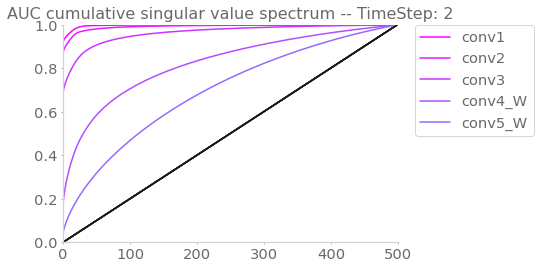

(526, 12864)
using 500 pcs; explaining 100.0% of the variance
(526, 8704)
using 500 pcs; explaining 100.0% of the variance
(526, 8704)
using 500 pcs; explaining 100.0% of the variance
(526, 17408)
using 500 pcs; explaining 99.7% of the variance
(526, 8704)
using 500 pcs; explaining 99.3% of the variance


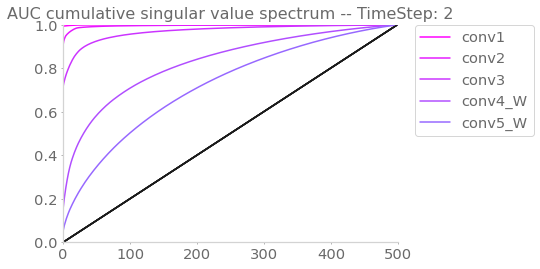

3
(526, 12864)
using 500 pcs; explaining 100.0% of the variance
(526, 8704)
using 500 pcs; explaining 100.0% of the variance
(526, 8704)
using 500 pcs; explaining 99.9% of the variance
(526, 17408)
using 500 pcs; explaining 99.3% of the variance
(526, 8704)
using 500 pcs; explaining 98.7% of the variance


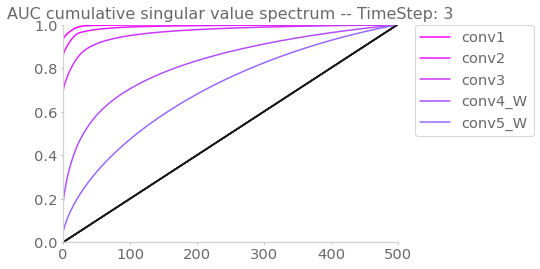

(526, 12864)
using 500 pcs; explaining 100.0% of the variance
(526, 8704)
using 500 pcs; explaining 100.0% of the variance
(526, 8704)
using 500 pcs; explaining 100.0% of the variance
(526, 17408)
using 500 pcs; explaining 99.7% of the variance
(526, 8704)
using 500 pcs; explaining 99.4% of the variance


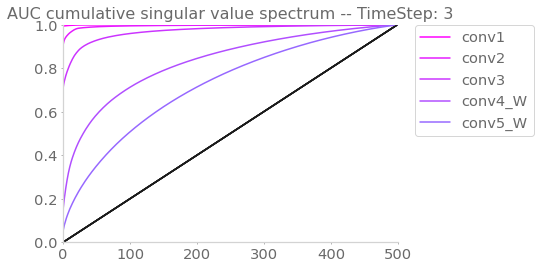

4
(526, 12864)
using 500 pcs; explaining 100.0% of the variance
(526, 8704)
using 500 pcs; explaining 100.0% of the variance
(526, 8704)
using 500 pcs; explaining 99.9% of the variance
(526, 17408)
using 500 pcs; explaining 99.3% of the variance
(526, 8704)
using 500 pcs; explaining 98.8% of the variance


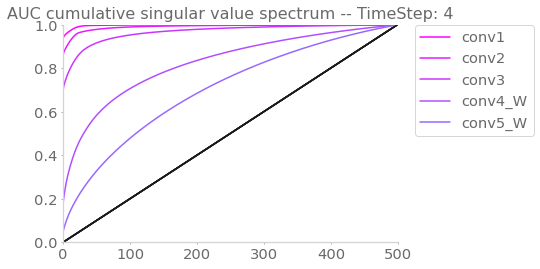

(526, 12864)
using 500 pcs; explaining 100.0% of the variance
(526, 8704)
using 500 pcs; explaining 100.0% of the variance
(526, 8704)
using 500 pcs; explaining 100.0% of the variance
(526, 17408)
using 500 pcs; explaining 99.7% of the variance
(526, 8704)
using 500 pcs; explaining 99.4% of the variance


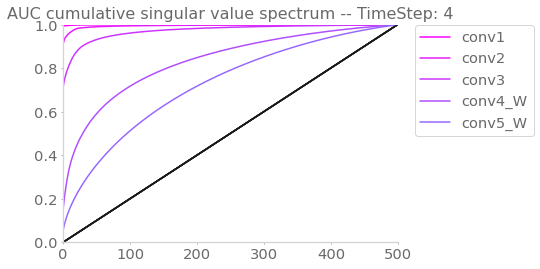

Babble8Spkr_snr3.hdf5
0
(565, 12864)
using 500 pcs; explaining 100.0% of the variance
(565, 8704)
using 500 pcs; explaining 99.8% of the variance
(565, 8704)
using 500 pcs; explaining 99.2% of the variance
(565, 17408)
using 500 pcs; explaining 98.1% of the variance
(565, 8704)
using 500 pcs; explaining 96.5% of the variance


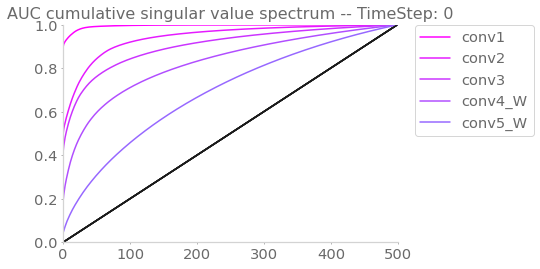

(565, 12864)
using 500 pcs; explaining 100.0% of the variance
(565, 8704)
using 500 pcs; explaining 99.7% of the variance
(565, 8704)
using 500 pcs; explaining 98.8% of the variance
(565, 17408)
using 500 pcs; explaining 97.4% of the variance
(565, 8704)
using 500 pcs; explaining 97.0% of the variance


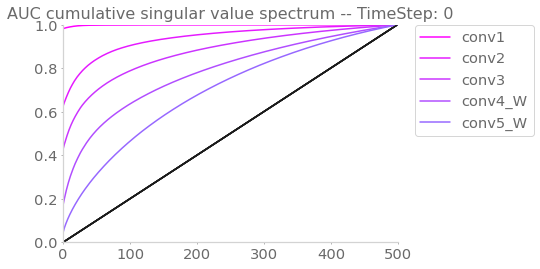

1
(565, 12864)
using 500 pcs; explaining 100.0% of the variance
(565, 8704)
using 500 pcs; explaining 99.9% of the variance
(565, 8704)
using 500 pcs; explaining 99.5% of the variance
(565, 17408)
using 500 pcs; explaining 98.2% of the variance
(565, 8704)
using 500 pcs; explaining 96.6% of the variance


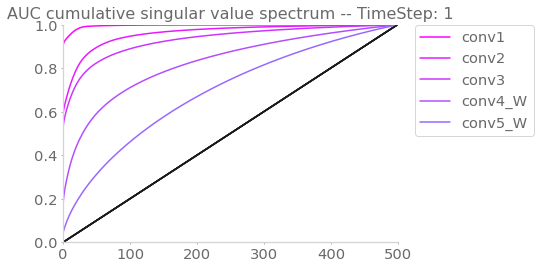

(565, 12864)
using 500 pcs; explaining 100.0% of the variance
(565, 8704)
using 500 pcs; explaining 99.8% of the variance
(565, 8704)
using 500 pcs; explaining 99.4% of the variance
(565, 17408)
using 500 pcs; explaining 97.8% of the variance
(565, 8704)
using 500 pcs; explaining 97.1% of the variance


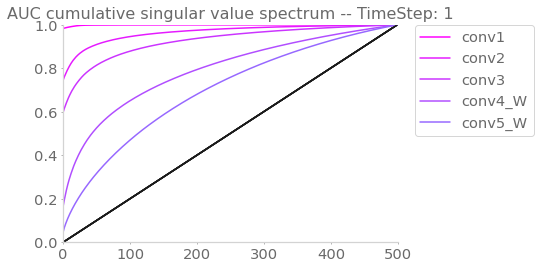

2
(565, 12864)
using 500 pcs; explaining 100.0% of the variance
(565, 8704)
using 500 pcs; explaining 99.9% of the variance
(565, 8704)
using 500 pcs; explaining 99.6% of the variance
(565, 17408)
using 500 pcs; explaining 98.3% of the variance
(565, 8704)
using 500 pcs; explaining 96.6% of the variance


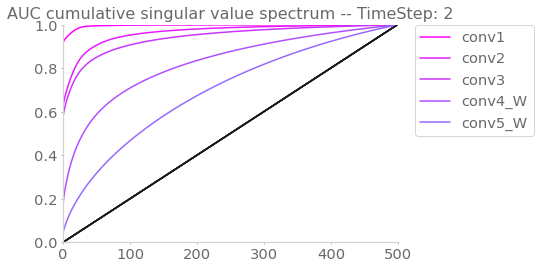

(565, 12864)
using 500 pcs; explaining 100.0% of the variance
(565, 8704)
using 500 pcs; explaining 99.9% of the variance
(565, 8704)
using 500 pcs; explaining 99.6% of the variance
(565, 17408)
using 500 pcs; explaining 98.0% of the variance
(565, 8704)
using 500 pcs; explaining 97.2% of the variance


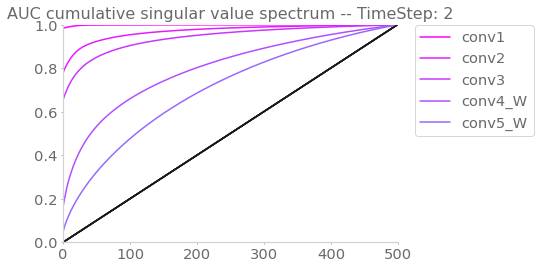

3
(565, 12864)
using 500 pcs; explaining 100.0% of the variance
(565, 8704)
using 500 pcs; explaining 99.9% of the variance
(565, 8704)
using 500 pcs; explaining 99.7% of the variance
(565, 17408)
using 500 pcs; explaining 98.3% of the variance
(565, 8704)
using 500 pcs; explaining 96.7% of the variance


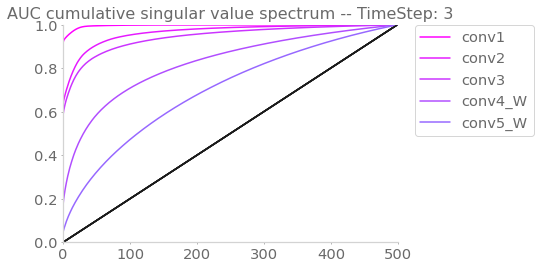

(565, 12864)
using 500 pcs; explaining 100.0% of the variance
(565, 8704)
using 500 pcs; explaining 99.9% of the variance
(565, 8704)
using 500 pcs; explaining 99.6% of the variance
(565, 17408)
using 500 pcs; explaining 98.2% of the variance
(565, 8704)
using 500 pcs; explaining 97.3% of the variance


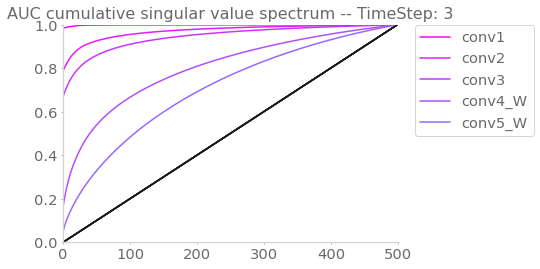

4
(565, 12864)
using 500 pcs; explaining 100.0% of the variance
(565, 8704)
using 500 pcs; explaining 99.9% of the variance
(565, 8704)
using 500 pcs; explaining 99.7% of the variance
(565, 17408)
using 500 pcs; explaining 98.3% of the variance
(565, 8704)
using 500 pcs; explaining 96.8% of the variance


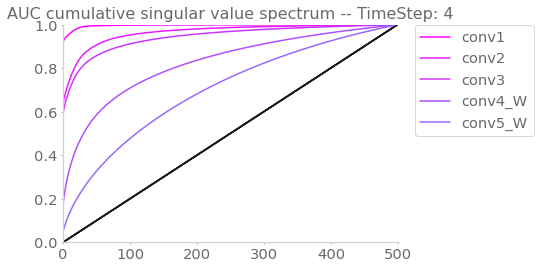

(565, 12864)
using 500 pcs; explaining 100.0% of the variance
(565, 8704)
using 500 pcs; explaining 99.9% of the variance
(565, 8704)
using 500 pcs; explaining 99.6% of the variance
(565, 17408)
using 500 pcs; explaining 98.3% of the variance
(565, 8704)
using 500 pcs; explaining 97.4% of the variance


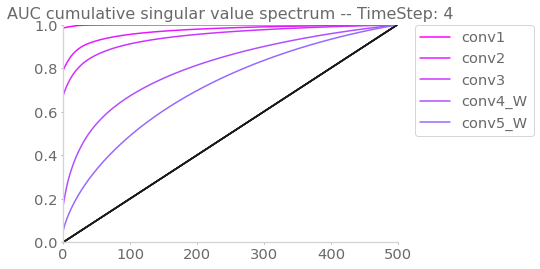

AudScene_snr3.hdf5
0
(567, 12864)
using 500 pcs; explaining 100.0% of the variance
(567, 8704)
using 500 pcs; explaining 99.8% of the variance
(567, 8704)
using 500 pcs; explaining 99.2% of the variance
(567, 17408)
using 500 pcs; explaining 98.0% of the variance
(567, 8704)
using 500 pcs; explaining 96.4% of the variance


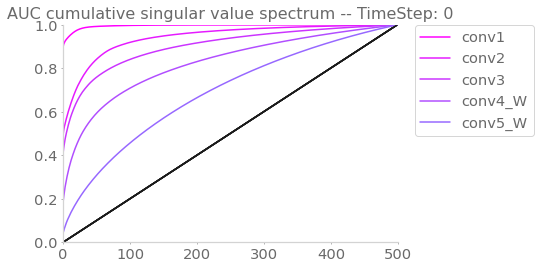

(567, 12864)
using 500 pcs; explaining 100.0% of the variance
(567, 8704)
using 500 pcs; explaining 99.7% of the variance
(567, 8704)
using 500 pcs; explaining 98.9% of the variance
(567, 17408)
using 500 pcs; explaining 97.7% of the variance
(567, 8704)
using 500 pcs; explaining 96.9% of the variance


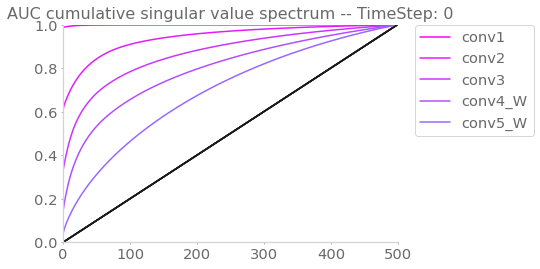

1
(567, 12864)
using 500 pcs; explaining 100.0% of the variance
(567, 8704)
using 500 pcs; explaining 100.0% of the variance
(567, 8704)
using 500 pcs; explaining 99.7% of the variance
(567, 17408)
using 500 pcs; explaining 98.1% of the variance
(567, 8704)
using 500 pcs; explaining 96.4% of the variance


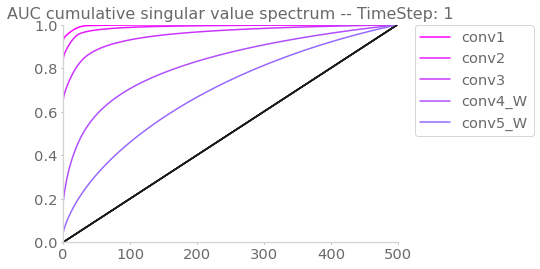

(567, 12864)
using 500 pcs; explaining 100.0% of the variance
(567, 8704)
using 500 pcs; explaining 100.0% of the variance
(567, 8704)
using 500 pcs; explaining 99.7% of the variance
(567, 17408)
using 500 pcs; explaining 98.1% of the variance
(567, 8704)
using 500 pcs; explaining 97.0% of the variance


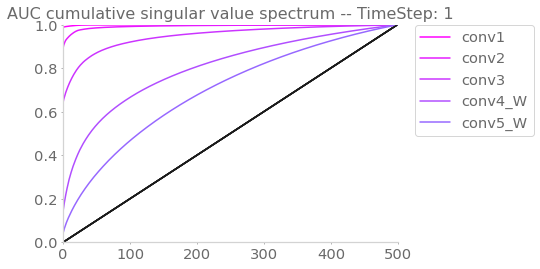

2
(567, 12864)
using 500 pcs; explaining 100.0% of the variance
(567, 8704)
using 500 pcs; explaining 100.0% of the variance
(567, 8704)
using 500 pcs; explaining 99.8% of the variance
(567, 17408)
using 500 pcs; explaining 98.2% of the variance
(567, 8704)
using 500 pcs; explaining 96.5% of the variance


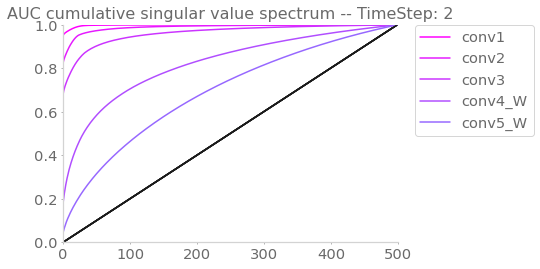

(567, 12864)
using 500 pcs; explaining 100.0% of the variance
(567, 8704)
using 500 pcs; explaining 100.0% of the variance
(567, 8704)
using 500 pcs; explaining 99.8% of the variance
(567, 17408)
using 500 pcs; explaining 98.3% of the variance
(567, 8704)
using 500 pcs; explaining 97.1% of the variance


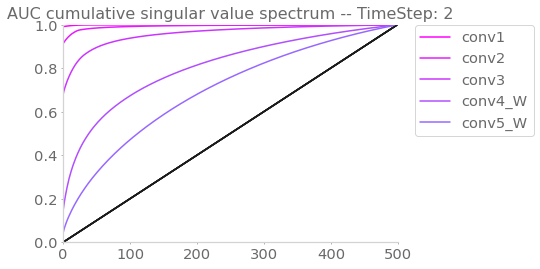

3
(567, 12864)
using 500 pcs; explaining 100.0% of the variance
(567, 8704)
using 500 pcs; explaining 100.0% of the variance
(567, 8704)
using 500 pcs; explaining 99.8% of the variance
(567, 17408)
using 500 pcs; explaining 98.2% of the variance
(567, 8704)
using 500 pcs; explaining 96.5% of the variance


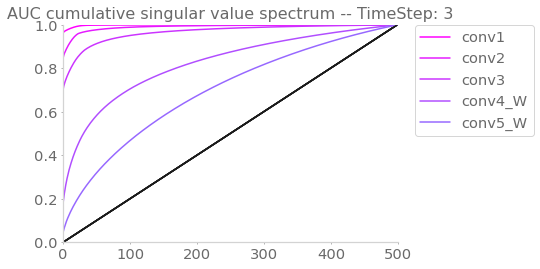

(567, 12864)
using 500 pcs; explaining 100.0% of the variance
(567, 8704)
using 500 pcs; explaining 100.0% of the variance
(567, 8704)
using 500 pcs; explaining 99.8% of the variance
(567, 17408)
using 500 pcs; explaining 98.4% of the variance
(567, 8704)
using 500 pcs; explaining 97.1% of the variance


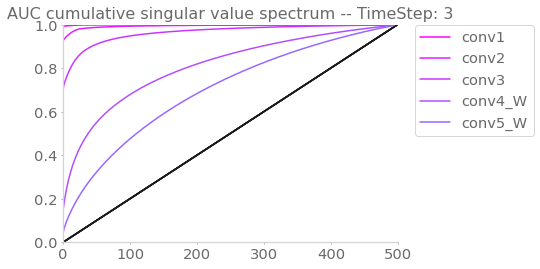

4
(567, 12864)
using 500 pcs; explaining 100.0% of the variance
(567, 8704)
using 500 pcs; explaining 100.0% of the variance
(567, 8704)
using 500 pcs; explaining 99.8% of the variance
(567, 17408)
using 500 pcs; explaining 98.2% of the variance
(567, 8704)
using 500 pcs; explaining 96.6% of the variance


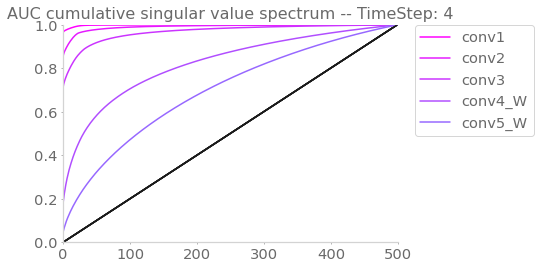

(567, 12864)
using 500 pcs; explaining 100.0% of the variance
(567, 8704)
using 500 pcs; explaining 100.0% of the variance
(567, 8704)
using 500 pcs; explaining 99.8% of the variance
(567, 17408)
using 500 pcs; explaining 98.4% of the variance
(567, 8704)
using 500 pcs; explaining 97.2% of the variance


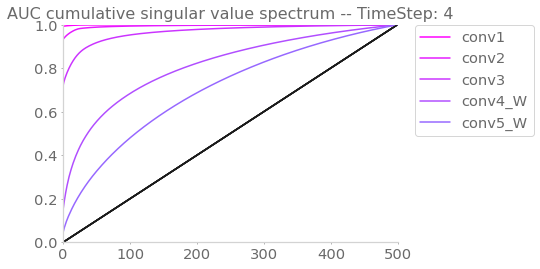

pinkNoise_snr-3.hdf5
0
(526, 12864)
using 500 pcs; explaining 100.0% of the variance
(526, 8704)
using 500 pcs; explaining 99.9% of the variance
(526, 8704)
using 500 pcs; explaining 99.7% of the variance
(526, 17408)
using 500 pcs; explaining 99.2% of the variance
(526, 8704)
using 500 pcs; explaining 98.7% of the variance


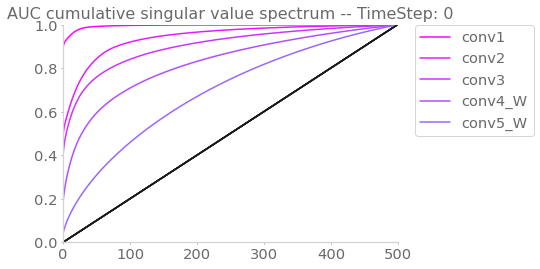

(526, 12864)
using 500 pcs; explaining 100.0% of the variance
(526, 8704)
using 500 pcs; explaining 100.0% of the variance
(526, 8704)
using 500 pcs; explaining 99.8% of the variance
(526, 17408)
using 500 pcs; explaining 99.6% of the variance
(526, 8704)
using 500 pcs; explaining 99.4% of the variance


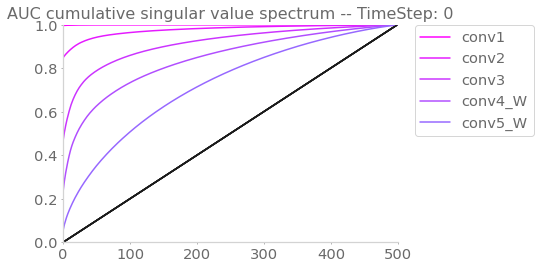

1
(526, 12864)
using 500 pcs; explaining 100.0% of the variance
(526, 8704)
using 500 pcs; explaining 100.0% of the variance
(526, 8704)
using 500 pcs; explaining 99.9% of the variance
(526, 17408)
using 500 pcs; explaining 99.3% of the variance
(526, 8704)
using 500 pcs; explaining 98.7% of the variance


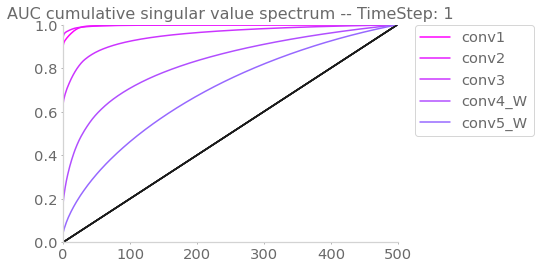

(526, 12864)
using 500 pcs; explaining 100.0% of the variance
(526, 8704)
using 500 pcs; explaining 100.0% of the variance
(526, 8704)
using 500 pcs; explaining 99.9% of the variance
(526, 17408)
using 500 pcs; explaining 99.7% of the variance
(526, 8704)
using 500 pcs; explaining 99.4% of the variance


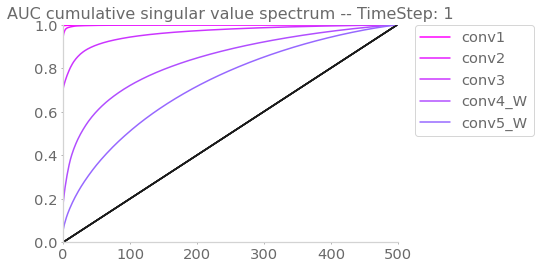

2
(526, 12864)
using 500 pcs; explaining 100.0% of the variance
(526, 8704)
using 500 pcs; explaining 100.0% of the variance
(526, 8704)
using 500 pcs; explaining 99.9% of the variance
(526, 17408)
using 500 pcs; explaining 99.3% of the variance
(526, 8704)
using 500 pcs; explaining 98.7% of the variance


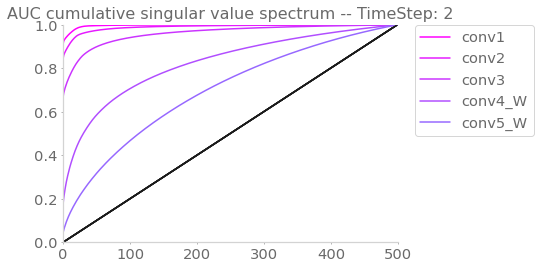

(526, 12864)
using 500 pcs; explaining 100.0% of the variance
(526, 8704)
using 500 pcs; explaining 100.0% of the variance
(526, 8704)
using 500 pcs; explaining 100.0% of the variance
(526, 17408)
using 500 pcs; explaining 99.8% of the variance
(526, 8704)
using 500 pcs; explaining 99.5% of the variance


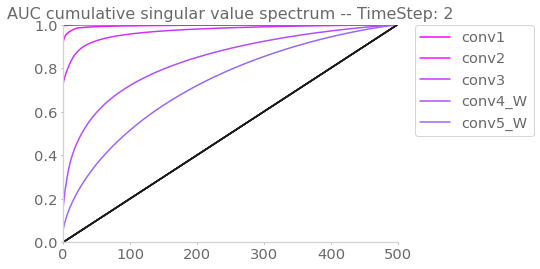

3
(526, 12864)
using 500 pcs; explaining 100.0% of the variance
(526, 8704)
using 500 pcs; explaining 100.0% of the variance
(526, 8704)
using 500 pcs; explaining 99.9% of the variance
(526, 17408)
using 500 pcs; explaining 99.3% of the variance
(526, 8704)
using 500 pcs; explaining 98.7% of the variance


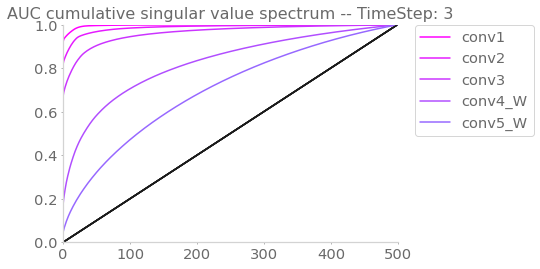

(526, 12864)
using 500 pcs; explaining 100.0% of the variance
(526, 8704)
using 500 pcs; explaining 100.0% of the variance
(526, 8704)
using 500 pcs; explaining 100.0% of the variance
(526, 17408)
using 500 pcs; explaining 99.8% of the variance
(526, 8704)
using 500 pcs; explaining 99.5% of the variance


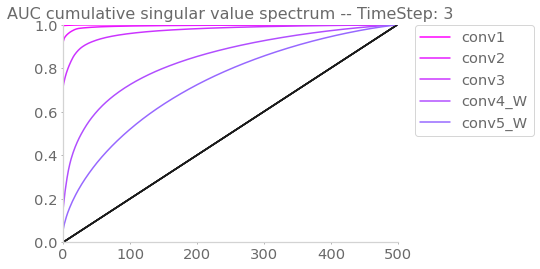

4
(526, 12864)
using 500 pcs; explaining 100.0% of the variance
(526, 8704)
using 500 pcs; explaining 100.0% of the variance
(526, 8704)
using 500 pcs; explaining 99.9% of the variance
(526, 17408)
using 500 pcs; explaining 99.3% of the variance
(526, 8704)
using 500 pcs; explaining 98.7% of the variance


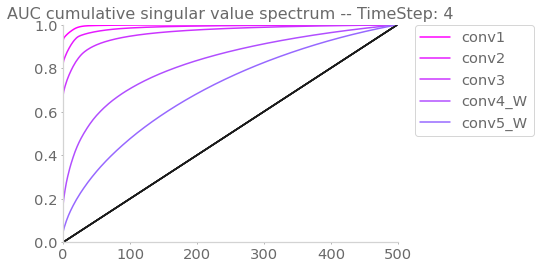

(526, 12864)
using 500 pcs; explaining 100.0% of the variance
(526, 8704)
using 500 pcs; explaining 100.0% of the variance
(526, 8704)
using 500 pcs; explaining 100.0% of the variance
(526, 17408)
using 500 pcs; explaining 99.8% of the variance
(526, 8704)
using 500 pcs; explaining 99.5% of the variance


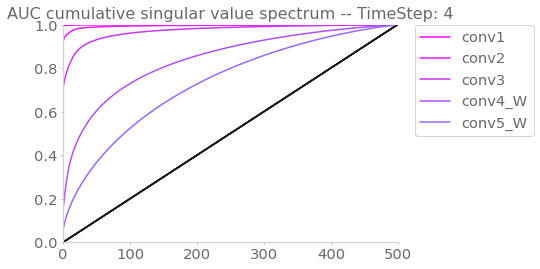

Babble8Spkr_snr0.hdf5
0
(566, 12864)
using 500 pcs; explaining 100.0% of the variance
(566, 8704)
using 500 pcs; explaining 99.8% of the variance
(566, 8704)
using 500 pcs; explaining 99.2% of the variance
(566, 17408)
using 500 pcs; explaining 98.0% of the variance
(566, 8704)
using 500 pcs; explaining 96.5% of the variance


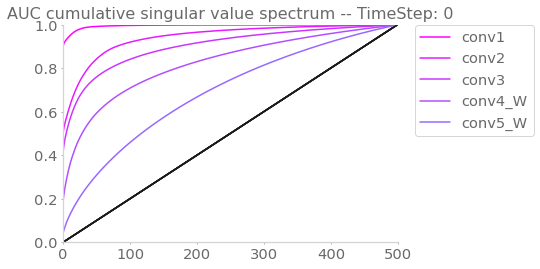

(566, 12864)
using 500 pcs; explaining 100.0% of the variance
(566, 8704)
using 500 pcs; explaining 99.7% of the variance
(566, 8704)
using 500 pcs; explaining 98.8% of the variance
(566, 17408)
using 500 pcs; explaining 97.1% of the variance
(566, 8704)
using 500 pcs; explaining 96.8% of the variance


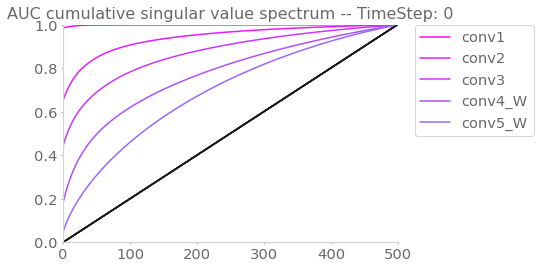

1
(566, 12864)
using 500 pcs; explaining 100.0% of the variance
(566, 8704)
using 500 pcs; explaining 99.9% of the variance
(566, 8704)
using 500 pcs; explaining 99.6% of the variance
(566, 17408)
using 500 pcs; explaining 98.2% of the variance
(566, 8704)
using 500 pcs; explaining 96.5% of the variance


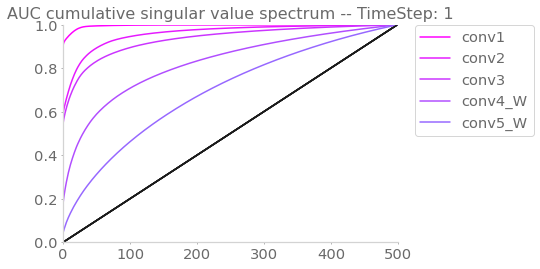

(566, 12864)
using 500 pcs; explaining 100.0% of the variance
(566, 8704)
using 500 pcs; explaining 99.8% of the variance
(566, 8704)
using 500 pcs; explaining 99.5% of the variance
(566, 17408)
using 500 pcs; explaining 97.5% of the variance
(566, 8704)
using 500 pcs; explaining 96.9% of the variance


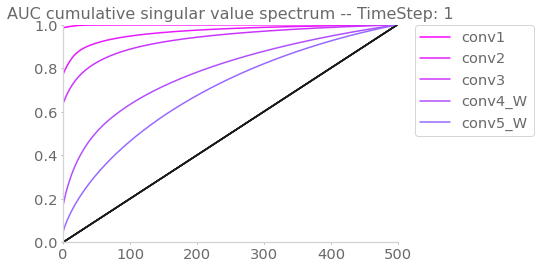

2
(566, 12864)
using 500 pcs; explaining 100.0% of the variance
(566, 8704)
using 500 pcs; explaining 99.9% of the variance
(566, 8704)
using 500 pcs; explaining 99.6% of the variance
(566, 17408)
using 500 pcs; explaining 98.2% of the variance
(566, 8704)
using 500 pcs; explaining 96.6% of the variance


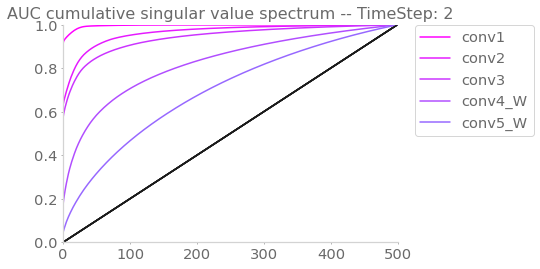

(566, 12864)
using 500 pcs; explaining 100.0% of the variance
(566, 8704)
using 500 pcs; explaining 99.9% of the variance
(566, 8704)
using 500 pcs; explaining 99.6% of the variance
(566, 17408)
using 500 pcs; explaining 97.8% of the variance
(566, 8704)
using 500 pcs; explaining 96.9% of the variance


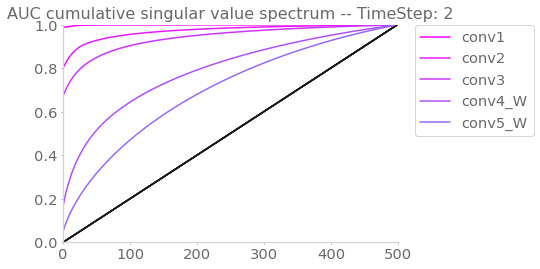

3
(566, 12864)
using 500 pcs; explaining 100.0% of the variance
(566, 8704)
using 500 pcs; explaining 99.9% of the variance
(566, 8704)
using 500 pcs; explaining 99.6% of the variance
(566, 17408)
using 500 pcs; explaining 98.3% of the variance
(566, 8704)
using 500 pcs; explaining 96.6% of the variance


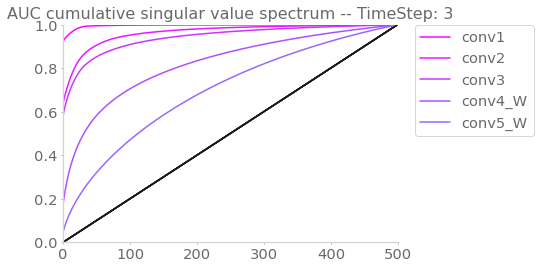

(566, 12864)
using 500 pcs; explaining 100.0% of the variance
(566, 8704)
using 500 pcs; explaining 99.9% of the variance
(566, 8704)
using 500 pcs; explaining 99.6% of the variance
(566, 17408)
using 500 pcs; explaining 98.0% of the variance
(566, 8704)
using 500 pcs; explaining 97.1% of the variance


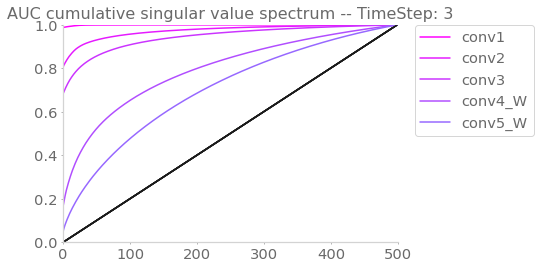

4
(566, 12864)
using 500 pcs; explaining 100.0% of the variance
(566, 8704)
using 500 pcs; explaining 99.9% of the variance
(566, 8704)
using 500 pcs; explaining 99.6% of the variance
(566, 17408)
using 500 pcs; explaining 98.3% of the variance
(566, 8704)
using 500 pcs; explaining 96.7% of the variance


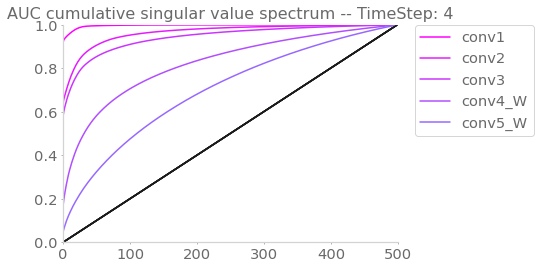

(566, 12864)
using 500 pcs; explaining 100.0% of the variance
(566, 8704)
using 500 pcs; explaining 99.9% of the variance
(566, 8704)
using 500 pcs; explaining 99.6% of the variance
(566, 17408)
using 500 pcs; explaining 98.1% of the variance
(566, 8704)
using 500 pcs; explaining 97.2% of the variance


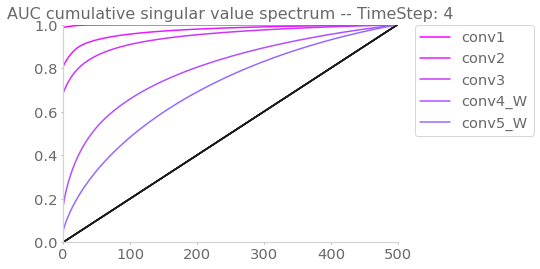

In [147]:
result_dict = {}
result_dict_clean = {}
acts_path = '/mnt/smb/locker/abbott-locker/hcnn/activations_pnet_all/'
layers = ['conv1', 'conv2', 'conv3', 'conv4_W', 'conv5_W']
for file in files[5:]:
    print(file)
    result_dict[file] =[]
    result_dict_clean[file] =[]
    for timestep in range(5):
        print(timestep)
        #result_dict_clean[file].append(plotCumSVS(layers, acts_path + file,  'AUC cumulative singular value spectrum -- TimeStep: '+str(timestep), timestep,clean=True))
        result_dict[file].append(plotCumSVS(layers, acts_path + file,  'AUC cumulative singular value spectrum -- TimeStep: '+str(timestep), timestep))

In [116]:
print(files)

['Babble8Spkr_snr-3.hdf5', 'AudScene_snr0.hdf5', 'pinkNoise_snr-9.hdf5', 'Babble8Spkr_snr-9.hdf5', 'natural_sounds.hdf5', 'AudScene_snr-3.hdf5', 'pinkNoise_snr3.hdf5', 'AudScene_snr-6.hdf5', 'Babble8Spkr_snr-6.hdf5', 'pinkNoise_snr-6.hdf5', 'AudScene_snr-9.hdf5', 'pinkNoise_snr0.hdf5', 'Babble8Spkr_snr3.hdf5', 'AudScene_snr3.hdf5', 'pinkNoise_snr-3.hdf5', 'Babble8Spkr_snr0.hdf5']


In [120]:
print(result_dict.keys())

dict_keys(['Babble8Spkr_snr-3.hdf5', 'AudScene_snr0.hdf5', 'pinkNoise_snr-9.hdf5', 'Babble8Spkr_snr-9.hdf5', 'natural_sounds.hdf5', 'AudScene_snr-3.hdf5', 'pinkNoise_snr3.hdf5', 'AudScene_snr-6.hdf5', 'Babble8Spkr_snr-6.hdf5', 'pinkNoise_snr-6.hdf5', 'AudScene_snr-9.hdf5', 'pinkNoise_snr0.hdf5', 'Babble8Spkr_snr3.hdf5', 'AudScene_snr3.hdf5', 'pinkNoise_snr-3.hdf5', 'Babble8Spkr_snr0.hdf5'])


In [24]:
to_mean_clean = []
for ii in range(5):
    to_mean = []
    for key in result_dict.keys():
        if key != 'natural_sounds.hdf5':
            to_mean.append(np.mean(np.array(result_dict[key]),axis=0))
           # to_mean_clean.append(np.mean(np.array(result_dict_clean[key]),axis=0))
to_mean = np.array(to_mean)
#to_mean_clean = np.array(to_mean_clean)
print(np.mean(to_mean,axis=0))
print(np.mean(to_mean_clean, axis=0))

[0.99774961 0.98278185 0.94605732 0.8189543  0.71027071]
nan


/home/es3773/.conda/envs/hcnn/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/es3773/.conda/envs/hcnn/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [26]:
import configs

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


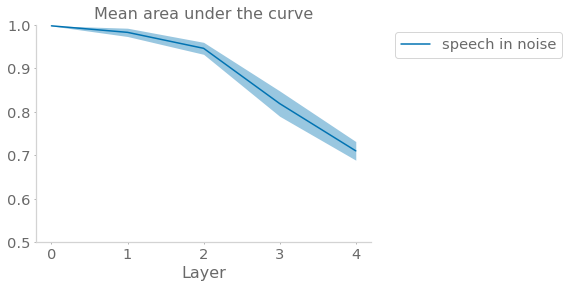

In [27]:
alpha, lw = 0.4, 5

plt.plot(np.mean(to_mean,axis=0), label='speech in noise')

plt.fill_between(range(5), np.mean(to_mean,axis=0)+np.std(to_mean,axis=0), np.mean(to_mean,axis=0)-np.std(to_mean,axis=0),  lw=0, alpha=alpha)
plt.ylim(.5,1)
#plt.plot(np.mean(to_mean_clean,axis=0), label = 'clean speech')
#plt.fill_between(range(5), np.mean(to_mean_clean,axis=0)+np.std(to_mean_clean,axis=0), np.mean(to_mean_clean,axis=0)-np.std(to_mean_clean,axis=0),  lw=0, alpha=alpha)


plt.title('Mean area under the curve')
plt.xlabel('Layer')
plt.xticks(range(5), range(5))
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.savefig('DimensionalityAcrossLayers.png', dpi=300)

In [134]:
plt.fillbetween?

Object `plt.fillbetween` not found.


In [159]:
to_mean_clean = []
for ii in range(5):
    to_mean = []
    for key in result_dict.keys():
        if key != 'natural_sounds.hdf5':
            to_mean.append(np.mean(np.array(result_dict[key]),axis=1))
            to_mean_clean.append(np.mean(np.array(result_dict_clean[key]),axis=1))
to_mean = np.array(to_mean)
to_mean_clean = np.array(to_mean_clean)
print(np.mean(to_mean,axis=0))
print(np.mean(to_mean_clean, axis=0))

[0.86869426 0.89176348 0.8957955  0.89864578 0.90091479]
[0.86918097 0.88795503 0.89005724 0.89171605 0.89309766]


In [158]:
np.shape(to_mean)

(15, 5)

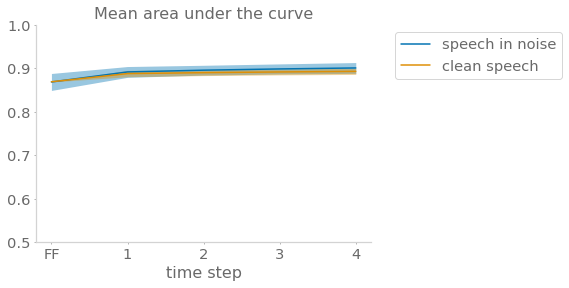

In [161]:
alpha, lw = 0.4, 5

plt.plot(np.mean(to_mean,axis=0), label='speech in noise')

plt.fill_between(range(5), np.mean(to_mean,axis=0)+np.std(to_mean,axis=0), np.mean(to_mean,axis=0)-np.std(to_mean,axis=0),  lw=0, alpha=alpha)
plt.ylim(.5,1)
plt.plot(np.mean(to_mean_clean,axis=0), label = 'clean speech')
plt.fill_between(range(5), np.mean(to_mean_clean,axis=0)+np.std(to_mean_clean,axis=0), np.mean(to_mean_clean,axis=0)-np.std(to_mean_clean,axis=0),  lw=0, alpha=alpha)


plt.title('Mean area under the curve')
plt.xlabel('layer')
plt.xticks(range(5), layers)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

plt.title('Mean area under the curve')
plt.xlabel('time step')
plt.xticks(range(5), ['FF', '1','2','3','4'])
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

In [169]:
print(files)

['Babble8Spkr_snr-3.hdf5', 'AudScene_snr0.hdf5', 'pinkNoise_snr-9.hdf5', 'Babble8Spkr_snr-9.hdf5', 'natural_sounds.hdf5', 'AudScene_snr-3.hdf5', 'pinkNoise_snr3.hdf5', 'AudScene_snr-6.hdf5', 'Babble8Spkr_snr-6.hdf5', 'pinkNoise_snr-6.hdf5', 'AudScene_snr-9.hdf5', 'pinkNoise_snr0.hdf5', 'Babble8Spkr_snr3.hdf5', 'AudScene_snr3.hdf5', 'pinkNoise_snr-3.hdf5', 'Babble8Spkr_snr0.hdf5']


In [173]:
inds =[]
for ii, f in enumerate(files):
    if 'Babble8Spkr' in f:
        inds.append(ii)

In [174]:
print(inds)

[0, 3, 8, 12, 15]


In [192]:
print(files)

['Babble8Spkr_snr-3.hdf5', 'AudScene_snr0.hdf5', 'pinkNoise_snr-9.hdf5', 'Babble8Spkr_snr-9.hdf5', 'natural_sounds.hdf5', 'AudScene_snr-3.hdf5', 'pinkNoise_snr3.hdf5', 'AudScene_snr-6.hdf5', 'Babble8Spkr_snr-6.hdf5', 'pinkNoise_snr-6.hdf5', 'AudScene_snr-9.hdf5', 'pinkNoise_snr0.hdf5', 'Babble8Spkr_snr3.hdf5', 'AudScene_snr3.hdf5', 'pinkNoise_snr-3.hdf5', 'Babble8Spkr_snr0.hdf5']


['pinkNoise_snr-9.hdf5']
['pinkNoise_snr-9.hdf5', 'pinkNoise_snr3.hdf5']
['pinkNoise_snr-9.hdf5', 'pinkNoise_snr3.hdf5', 'pinkNoise_snr-6.hdf5']
['pinkNoise_snr-9.hdf5', 'pinkNoise_snr3.hdf5', 'pinkNoise_snr-6.hdf5', 'pinkNoise_snr0.hdf5']
['pinkNoise_snr-9.hdf5', 'pinkNoise_snr3.hdf5', 'pinkNoise_snr-6.hdf5', 'pinkNoise_snr0.hdf5', 'pinkNoise_snr-3.hdf5']


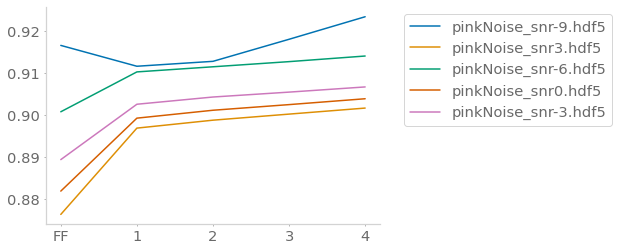

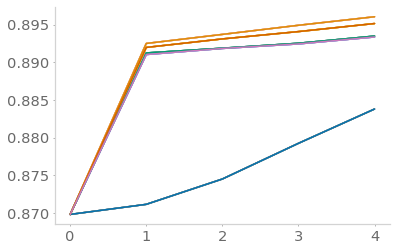

In [193]:
to_mean_clean = []
labels= []
for ii in range(5):
    to_mean = []
    for key in result_dict.keys():
        if 'pinkNoise' in key:
            to_mean.append(np.mean(np.array(result_dict[]),axis=1))
            to_mean_clean.append(np.mean(np.array(result_dict_clean[key]),axis=1))
        
            if ii ==0:
                labels.append(key)
                print(labels)

to_mean = np.array(to_mean)
to_mean_clean = np.array(to_mean_clean)

for ii in range(len(labels)):
    plt.plot(to_mean[ii], label = labels[ii])

plt.xticks(range(5), ['FF', '1','2','3','4'])
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

plt.plot(to_mean_clean.T)
plt.show()


In [14]:
result_dict = np.load('result_dict.npy', allow_pickle=True)[()]

In [30]:
to_mean_clean = []
to_mean_err = []
labels= []
for ii in range(5):
    to_mean = []
    for snr in [-9,-6,-3,0,3]:
        temp= []
        for key in ['Babble8Spkr', 'AudScene', 'pinkNoise']:
            temp.append(np.mean(np.array(result_dict[key+'_snr'+str(snr)+'.hdf5']),axis=1))
        to_mean_err.append(np.std(np.array(temp),axis=0))
        to_mean.append(np.mean(np.array(temp),axis=0))
      




In [31]:
print(np.array(to_mean))

[[0.87641461 0.90412047 0.90839402 0.9131414  0.91753958]
 [0.8712173  0.89577916 0.89966024 0.90236408 0.90442558]
 [0.86720615 0.88712372 0.89199057 0.89444371 0.89611197]
 [0.86502805 0.88596261 0.88925225 0.89134024 0.89291078]
 [0.86360518 0.88583142 0.88968042 0.89193948 0.89358601]]


[array([0.87641461, 0.90412047, 0.90839402, 0.9131414 , 0.91753958]), array([0.8712173 , 0.89577916, 0.89966024, 0.90236408, 0.90442558]), array([0.86720615, 0.88712372, 0.89199057, 0.89444371, 0.89611197]), array([0.86502805, 0.88596261, 0.88925225, 0.89134024, 0.89291078]), array([0.86360518, 0.88583142, 0.88968042, 0.89193948, 0.89358601])]


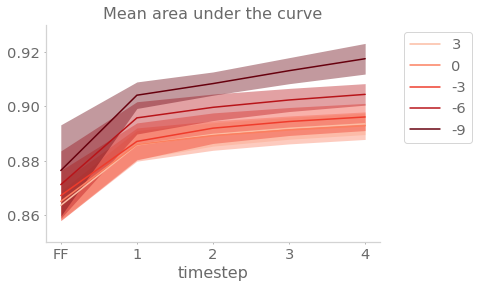

In [32]:
print(to_mean)
import matplotlib.pylab as pl
from matplotlib import cm
snrs = [-9,-6,-3,0,3]
to_mean = np.array(to_mean)
colors = cm.get_cmap('Reds_r')(np.linspace(0.,0.75,5))
for ii in range(5):
    ii = 5-ii-1
    plt.plot(to_mean[ii], label=snrs[ii], color=colors[ii])
    plt.fill_between(
        range(5), to_mean[ii] + to_mean_err[ii]/(3)**.5,
        to_mean[ii] - to_mean_err[ii]/(3)**.5,
        color=colors[ii], lw=0, alpha=alpha
        )

    plt.xticks(range(5), ['FF', '1','2','3','4'])
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.title('Mean area under the curve')

    plt.xlabel('timestep')
    plt.ylim(.85,.93)
    plt.savefig("Dimensionality"+str(ii)+".svg")
plt.show()

In [33]:
result_dict = np.load('result_dict.npy', allow_pickle=True)[()]

In [34]:
result_dict.keys()

dict_keys(['Babble8Spkr_snr-3.hdf5', 'AudScene_snr0.hdf5', 'pinkNoise_snr-9.hdf5', 'Babble8Spkr_snr-9.hdf5', 'natural_sounds.hdf5', 'AudScene_snr-3.hdf5', 'pinkNoise_snr3.hdf5', 'AudScene_snr-6.hdf5', 'Babble8Spkr_snr-6.hdf5', 'pinkNoise_snr-6.hdf5', 'AudScene_snr-9.hdf5', 'pinkNoise_snr0.hdf5', 'Babble8Spkr_snr3.hdf5', 'AudScene_snr3.hdf5', 'pinkNoise_snr-3.hdf5', 'Babble8Spkr_snr0.hdf5'])

[[0.87641461 0.90412047 0.90839402 0.9131414  0.91753958]
 [0.8712173  0.89577916 0.89966024 0.90236408 0.90442558]
 [0.86720615 0.88712372 0.89199057 0.89444371 0.89611197]
 [0.86502805 0.88596261 0.88925225 0.89134024 0.89291078]
 [0.86360518 0.88583142 0.88968042 0.89193948 0.89358601]]


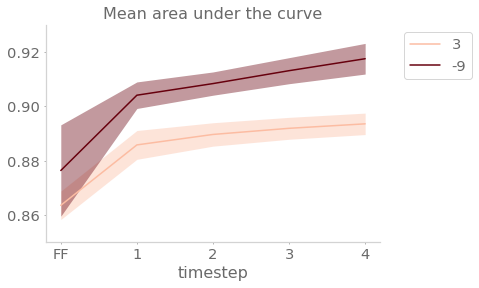

In [35]:
alpha, lw = 0.4, 5
print(to_mean)
import matplotlib.pylab as pl
from matplotlib import cm
snrs = [-9,-6,-3,0,3]
to_mean = np.array(to_mean)
colors = cm.get_cmap('Reds_r')(np.linspace(0.,0.75,5))
for ii in [4,0]:
    
    plt.plot(to_mean[ii], label=snrs[ii], color=colors[ii])
    plt.fill_between(
        range(5), to_mean[ii] + to_mean_err[ii]/(3)**.5,
        to_mean[ii] - to_mean_err[ii]/(3)**.5,
        color=colors[ii], lw=0, alpha=alpha
        )

    plt.xticks(range(5), ['FF', '1','2','3','4'])
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.title('Mean area under the curve')

    plt.xlabel('timestep')
    plt.ylim(.85,.93)
    plt.savefig("Dimensionality"+str(ii)+".png", dpi=300)
plt.show()

In [168]:
np.save('result_dict', result_dict)

In [187]:
act_path = '/mnt/smb/locker/abbott-locker/hcnn/activations_pnet_all/Babble8Spkr_snr-3.hdf5'

with h5py.File(act_path, 'r') as f_in:

        
            
        activation_clean = timeAverage(f_in[layer+'_'+str(timestep)+'_clean_activations'],  layer)
        activation = timeAverage(f_in[layer+'_'+str(timestep)+'_activations'],  layer)


In [185]:
files[0]

'Babble8Spkr_snr-3.hdf5'

In [188]:
print(np.sum(activation_clean))

79950070.0


In [189]:
print(np.sum(activation))

96886740.0


['pinkNoise_snr-9.hdf5']
['pinkNoise_snr-9.hdf5', 'pinkNoise_snr3.hdf5']
['pinkNoise_snr-9.hdf5', 'pinkNoise_snr3.hdf5', 'pinkNoise_snr-6.hdf5']
['pinkNoise_snr-9.hdf5', 'pinkNoise_snr3.hdf5', 'pinkNoise_snr-6.hdf5', 'pinkNoise_snr0.hdf5']
['pinkNoise_snr-9.hdf5', 'pinkNoise_snr3.hdf5', 'pinkNoise_snr-6.hdf5', 'pinkNoise_snr0.hdf5', 'pinkNoise_snr-3.hdf5']


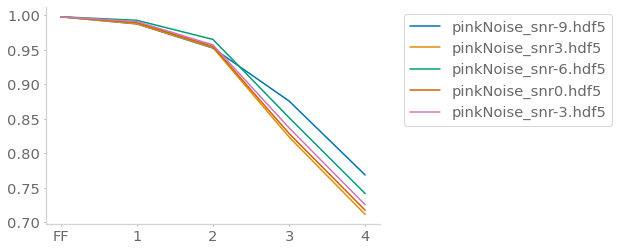

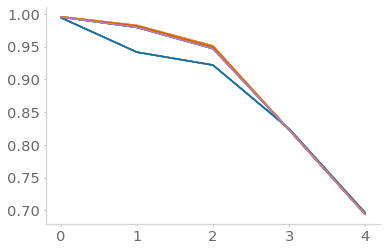

In [195]:
to_mean_clean = []
labels= []
for ii in range(5):
    to_mean = []
    for key in result_dict.keys():
        if 'pinkNoise' in key:
            to_mean.append(np.mean(np.array(result_dict[key]),axis=0))
            to_mean_clean.append(np.mean(np.array(result_dict_clean[key]),axis=0))
        
            if ii ==0:
                labels.append(key)
                print(labels)

to_mean = np.array(to_mean)
to_mean_clean = np.array(to_mean_clean)

for ii in range(len(labels)):
    plt.plot(to_mean[ii], label = labels[ii])

plt.xticks(range(5), ['FF', '1','2','3','4'])
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

plt.plot(to_mean_clean.T)
plt.show()


0
(568, 12864)
using 500 pcs; explaining 100.0% of the variance


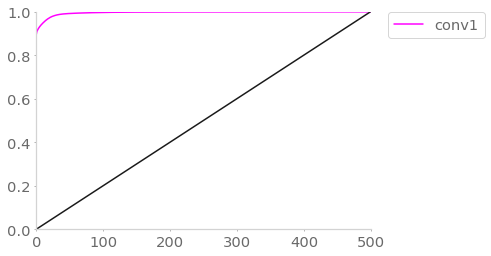

In [209]:
acts_path = '/mnt/smb/locker/abbott-locker/hcnn/activations_pnet_all/'
layers = ['conv1']
file = 'AudScene_snr-3.hdf5'
result_dict[file] =[]
result_dict_clean[file] =[]
for timestep in range(1):
    print(timestep)
    result_dict[file].append(plotCumSVS(layers, acts_path + file,  '', timestep, clean=True))

(566, 12864)
using 500 pcs; explaining 100.0% of the variance
(566, 8704)
using 500 pcs; explaining 99.7% of the variance
(566, 8704)
using 500 pcs; explaining 98.7% of the variance
(566, 17408)
using 500 pcs; explaining 96.9% of the variance
(566, 8704)
using 500 pcs; explaining 96.2% of the variance


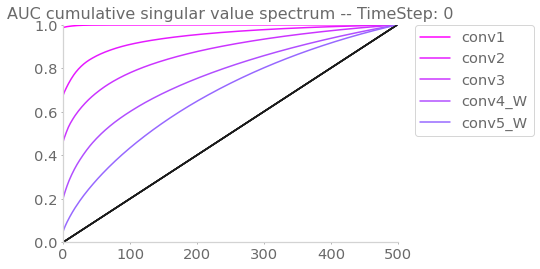

(566, 12864)
using 500 pcs; explaining 100.0% of the variance
(566, 8704)
using 500 pcs; explaining 100.0% of the variance
(566, 8704)
using 500 pcs; explaining 99.9% of the variance
(566, 17408)
using 500 pcs; explaining 98.3% of the variance
(566, 8704)
using 500 pcs; explaining 96.4% of the variance


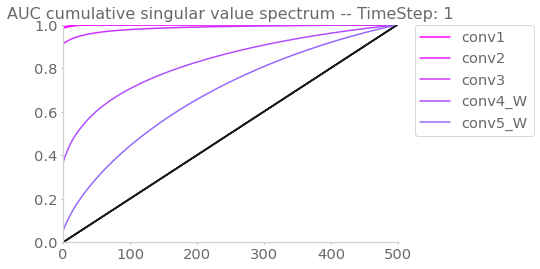

(566, 12864)
using 500 pcs; explaining 100.0% of the variance
(566, 8704)
using 500 pcs; explaining 100.0% of the variance
(566, 8704)
using 500 pcs; explaining 100.0% of the variance
(566, 17408)
using 500 pcs; explaining 98.6% of the variance
(566, 8704)
using 500 pcs; explaining 96.5% of the variance


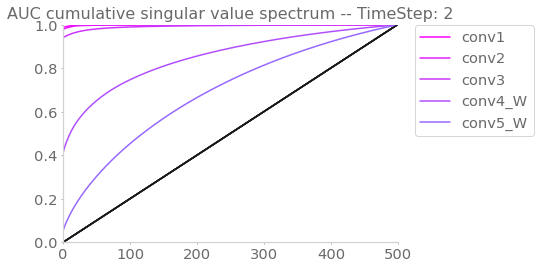

(566, 12864)
using 500 pcs; explaining 100.0% of the variance
(566, 8704)
using 500 pcs; explaining 100.0% of the variance
(566, 8704)
using 500 pcs; explaining 100.0% of the variance
(566, 17408)
using 500 pcs; explaining 98.8% of the variance
(566, 8704)
using 500 pcs; explaining 96.7% of the variance


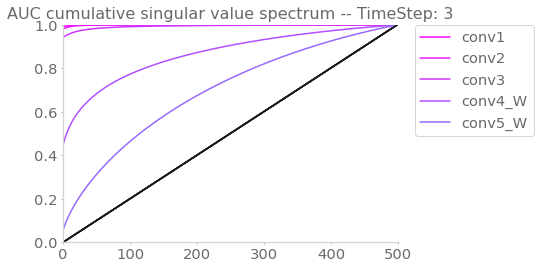

(566, 12864)
using 500 pcs; explaining 100.0% of the variance
(566, 8704)
using 500 pcs; explaining 100.0% of the variance
(566, 8704)
using 500 pcs; explaining 100.0% of the variance
(566, 17408)
using 500 pcs; explaining 99.0% of the variance
(566, 8704)
using 500 pcs; explaining 96.9% of the variance


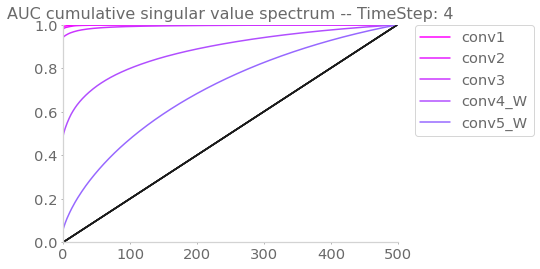

In [281]:
noisy_auc = []

acts_path = '/mnt/smb/locker/abbott-locker/hcnn/activations_random/Babble8Spkr_snr-9/'
layers = ['conv1', 'conv2', 'conv3', 'conv4_W', 'conv5_W']

for timestep in range(5):
    noisy_auc.append(plotCumSVS(layers, acts_path + '208776.3.hdf5',  'AUC cumulative singular value spectrum -- TimeStep: '+str(timestep), timestep))